In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import AutoLocator,AutoMinorLocator,MultipleLocator
import seaborn as sns
import itertools
import datetime
import time
from astro_tools import mc_stats 
sns.set_color_codes(palette='colorblind')
%matplotlib notebook

from IPython.display import display, HTML
display(HTML(data="""
<style>div#notebook-container    { width: 95%; }
 div#menubar-container     { width: 65%; }  
div#maintoolbar-container { width: 99%; }
</style>
"""))
plt.style.use('dark_background')
sns.set_color_codes(palette='colorblind')

/Users/pwise/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Dog Spotting

In [2]:
dogspotting = pd.read_csv('dogspotting_raw.csv',header=0,skiprows=[1],skipfooter=1)
dogspotting.drop('Unnamed: 0',axis=1,inplace=True)

def quadrature(z,x,ex,y,ey):
    return z*(((ex/x)**2+(ey/y)**2)**0.5)

/Users/pwise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [3]:
dogspotting.dropna(subset=['Observer'],inplace=True)

In [4]:
# Turn start and end times into datetimes
dogspotting['dt_start'] =pd.to_datetime(dogspotting['Date'] + ' ' + dogspotting['Time Start'])
dogspotting['dt_end'] =pd.to_datetime(dogspotting['Date'] + ' ' + dogspotting['Time End'])
# Subtract start time from end time to create a duration timedelta
dt = dogspotting['dt_end'] - dogspotting['dt_start']
dogspotting['duration']  = dt.apply(lambda x: x.seconds)

<IPython.core.display.Javascript object>


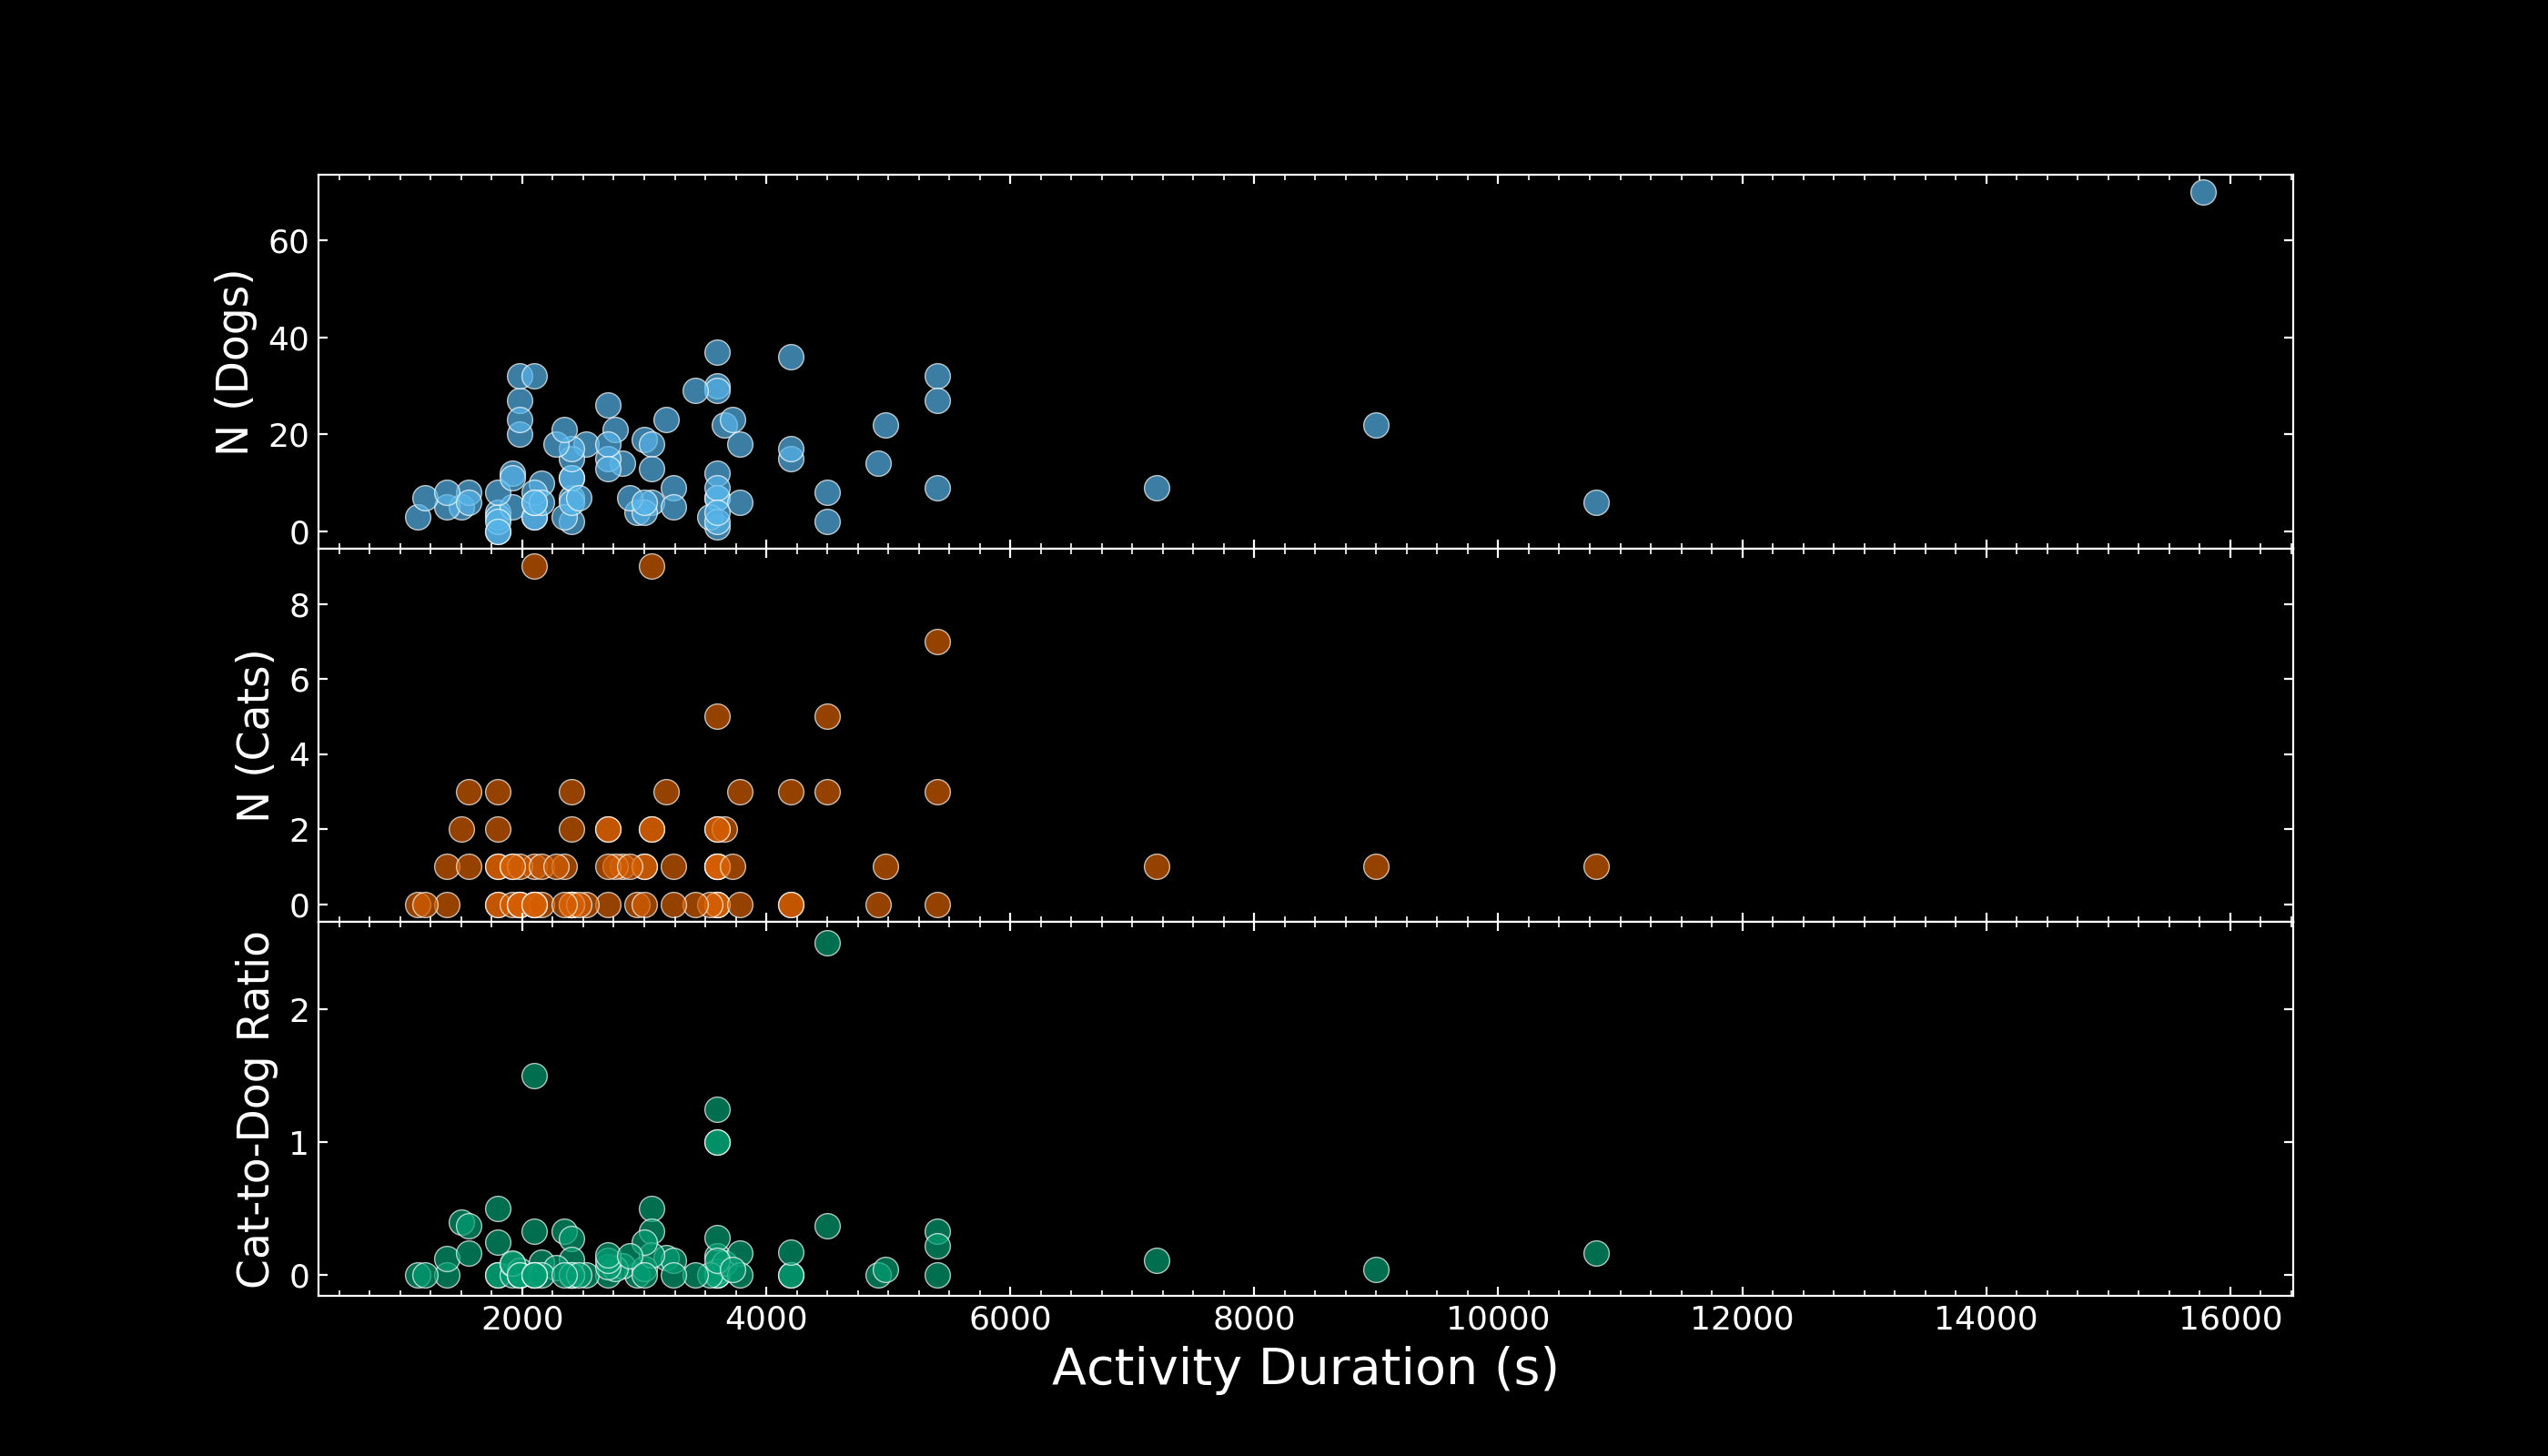

In [5]:
# Plot scatter plots comparing to time
f,(axdogs,axcats,axcdr)= plt.subplots(3,sharex=True,figsize=(14,8))
dogspotting.plot.scatter('duration','N (Dogs)',ax=axdogs,marker='o',s=100,alpha=0.7,linewidth=0.5,edgecolor='w',c='c')
axdogs.set_ylabel('N (Dogs)',size=17)
dogspotting.plot.scatter('duration','N (Cats)',ax=axcats,marker='o',s=100,alpha=0.7,linewidth=0.5,edgecolor='w',c='r')
axcats.set_ylabel('N (Cats)',size=17)

axcdr.scatter(dogspotting['duration'],dogspotting['N (Cats)']/dogspotting['N (Dogs)'],marker='o',s=100,alpha=0.7,linewidth=0.5,edgecolor='w',c='g')
axcdr.set_ylabel('Cat-to-Dog Ratio',size=17)
axcdr.set_xlabel('Activity Duration (s)',size=20)
#axcdr.set_xlim(1000,6000)
#axdogs.set_ylim(-2,40)
#axcdr.set_xscale('log')
for ax in [axdogs,axcats,axcdr]:
    ax.xaxis.set_minor_locator(MultipleLocator(250))
    ax.tick_params(which='both',direction='in',top=True,right=True,labelsize=13)
plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig('figs/animals_vs_time')

<IPython.core.display.Javascript object>


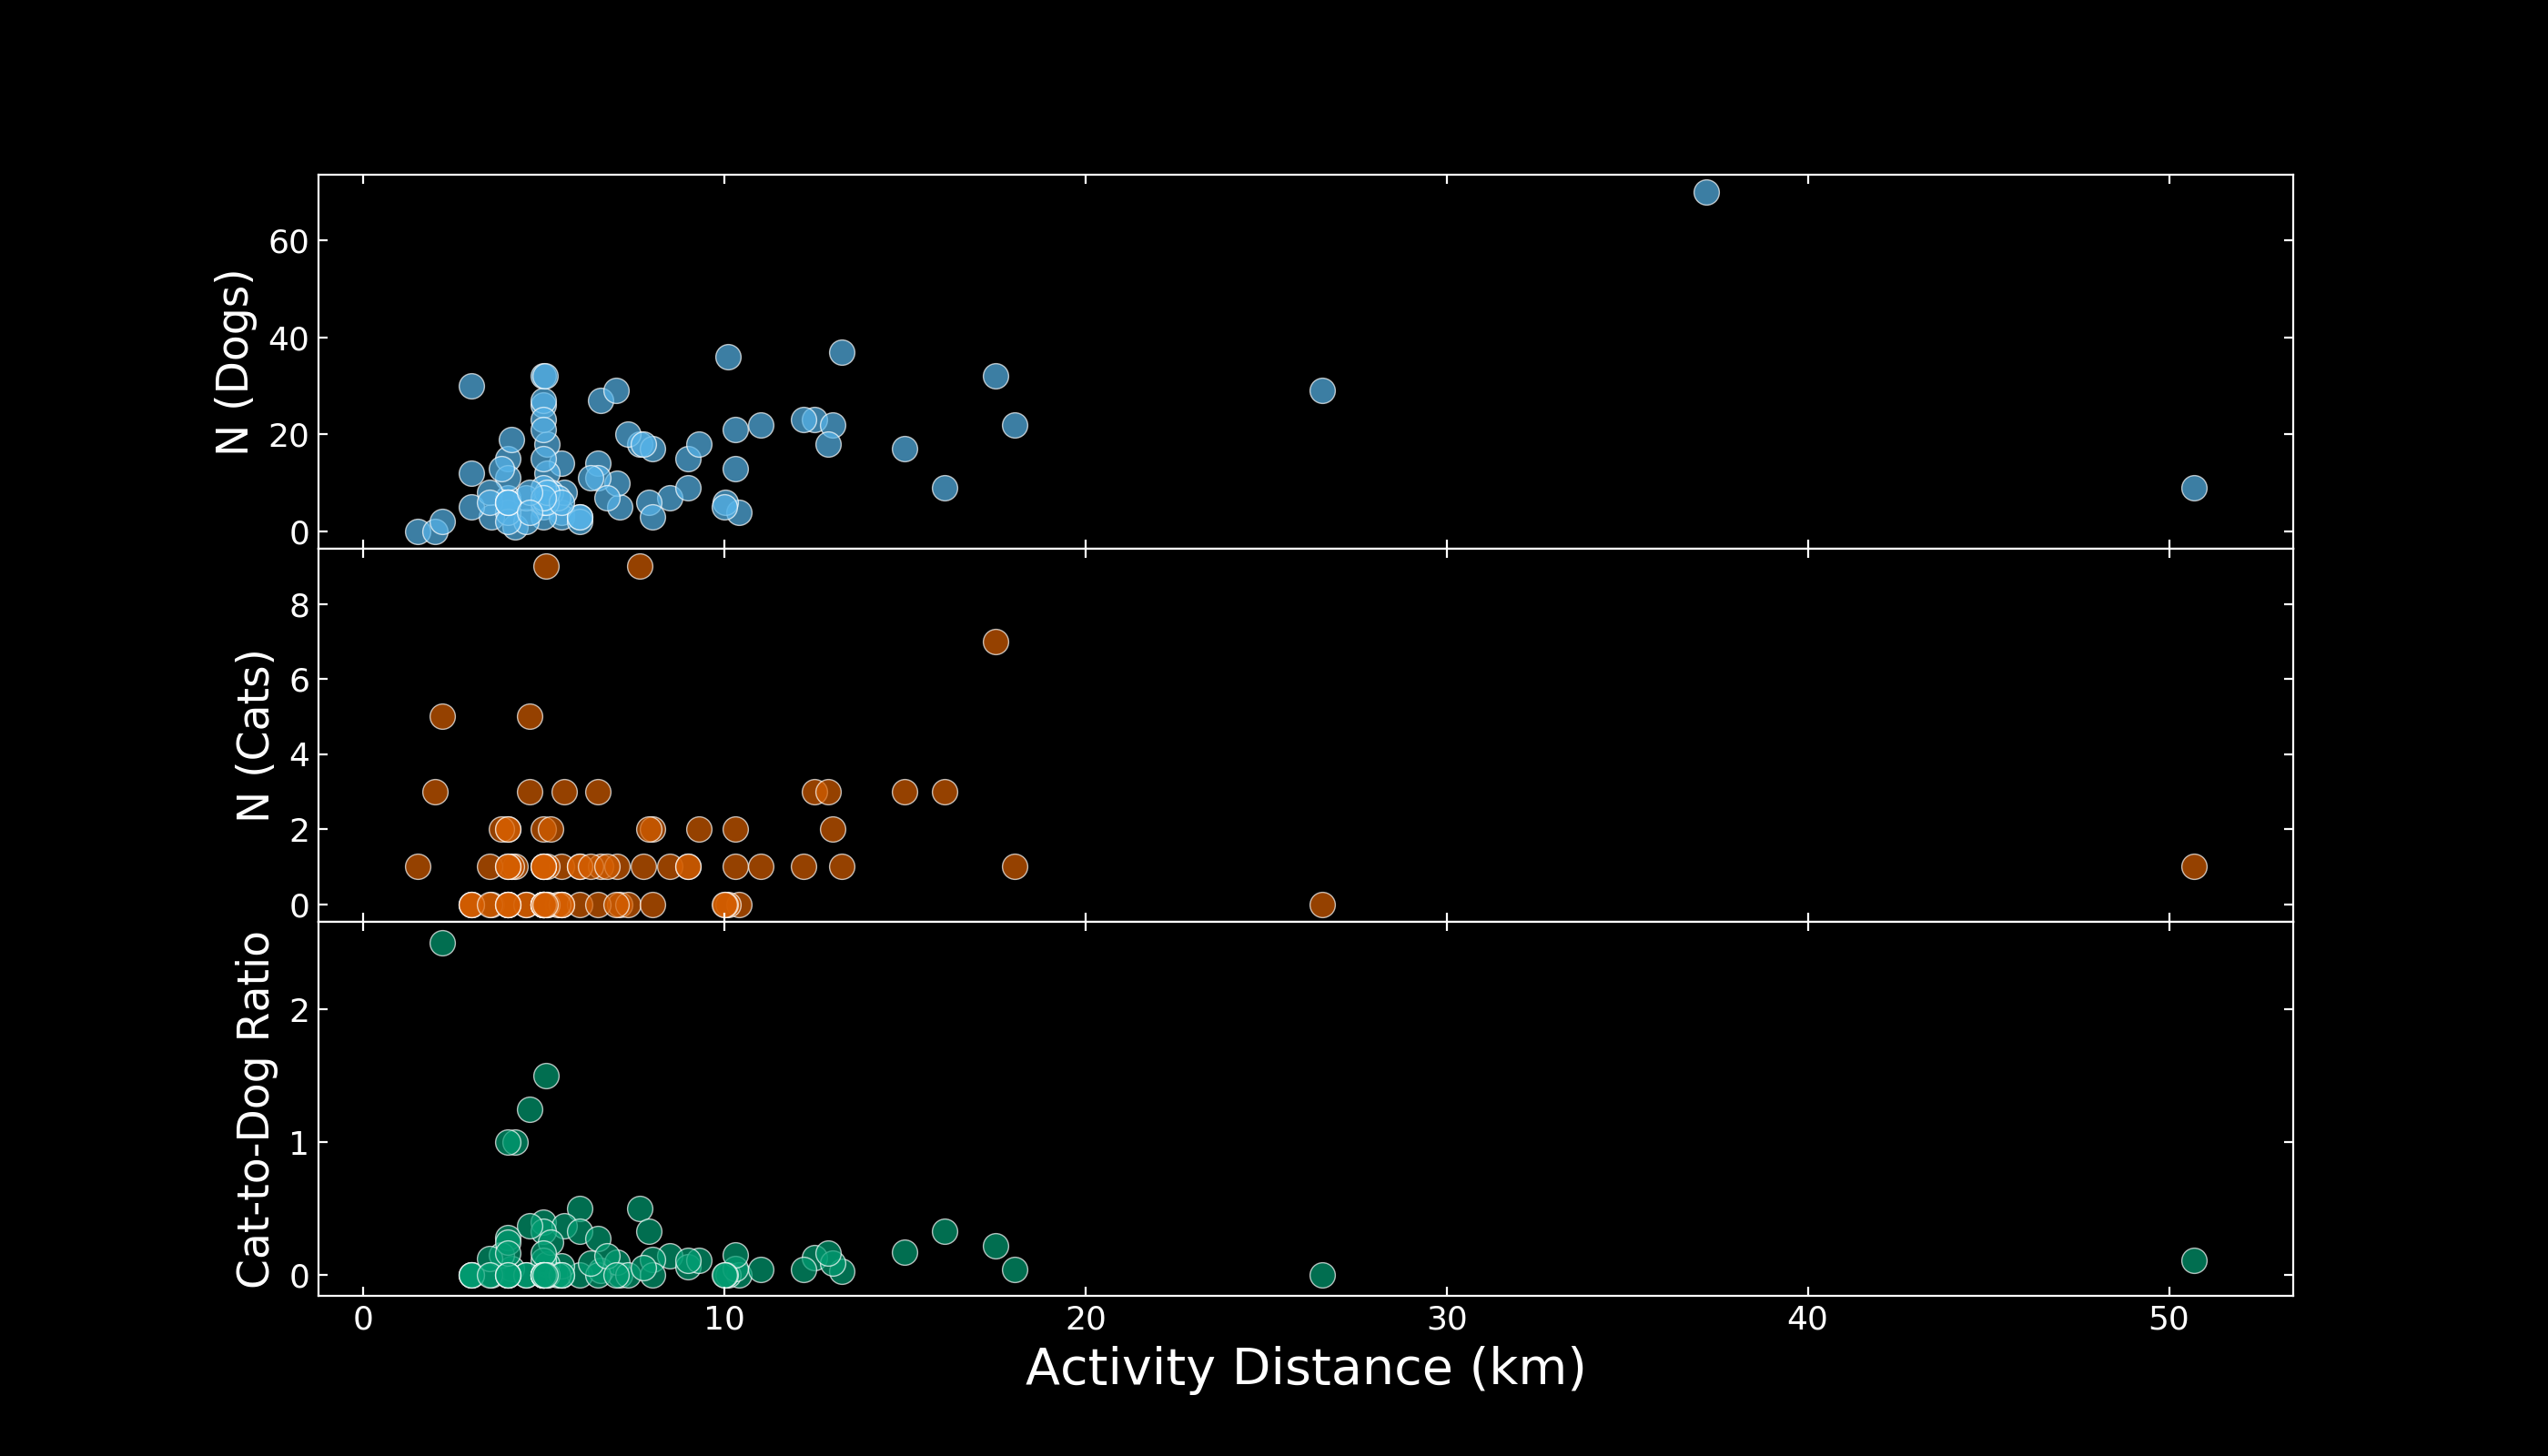

In [6]:
# Plot scatter plots comparing to distance
f,(axdogs,axcats,axcdr)= plt.subplots(3,sharex=True,figsize=(14,8))
dogspotting.plot.scatter('Distance (km)','N (Dogs)',ax=axdogs,marker='o',s=100,alpha=0.7,linewidth=0.5,edgecolor='w',c='c')
axdogs.set_ylabel('N (Dogs)',size=17)
dogspotting.plot.scatter('Distance (km)','N (Cats)',ax=axcats,marker='o',s=100,alpha=0.7,linewidth=0.5,edgecolor='w',c='r')
axcats.set_ylabel('N (Cats)',size=17)

axcdr.scatter(dogspotting['Distance (km)'],dogspotting['N (Cats)']/dogspotting['N (Dogs)'],marker='o',s=100,alpha=0.7,linewidth=0.5,edgecolor='w',c='g')
axcdr.set_ylabel('Cat-to-Dog Ratio',size=17)
axcdr.set_xlabel('Activity Distance (km)',size=20)
#axcdr.set_xlim(0,17)
#axdogs.set_ylim(-2,40)
#axcdr.set_xscale('log')
for ax in [axdogs,axcats,axcdr]:
    ax.xaxis.set_minor_locator(MultipleLocator(250))
    ax.tick_params(which='both',direction='in',top=True,right=True,labelsize=13)
plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig('figs/animals_vs_distance')

<IPython.core.display.Javascript object>


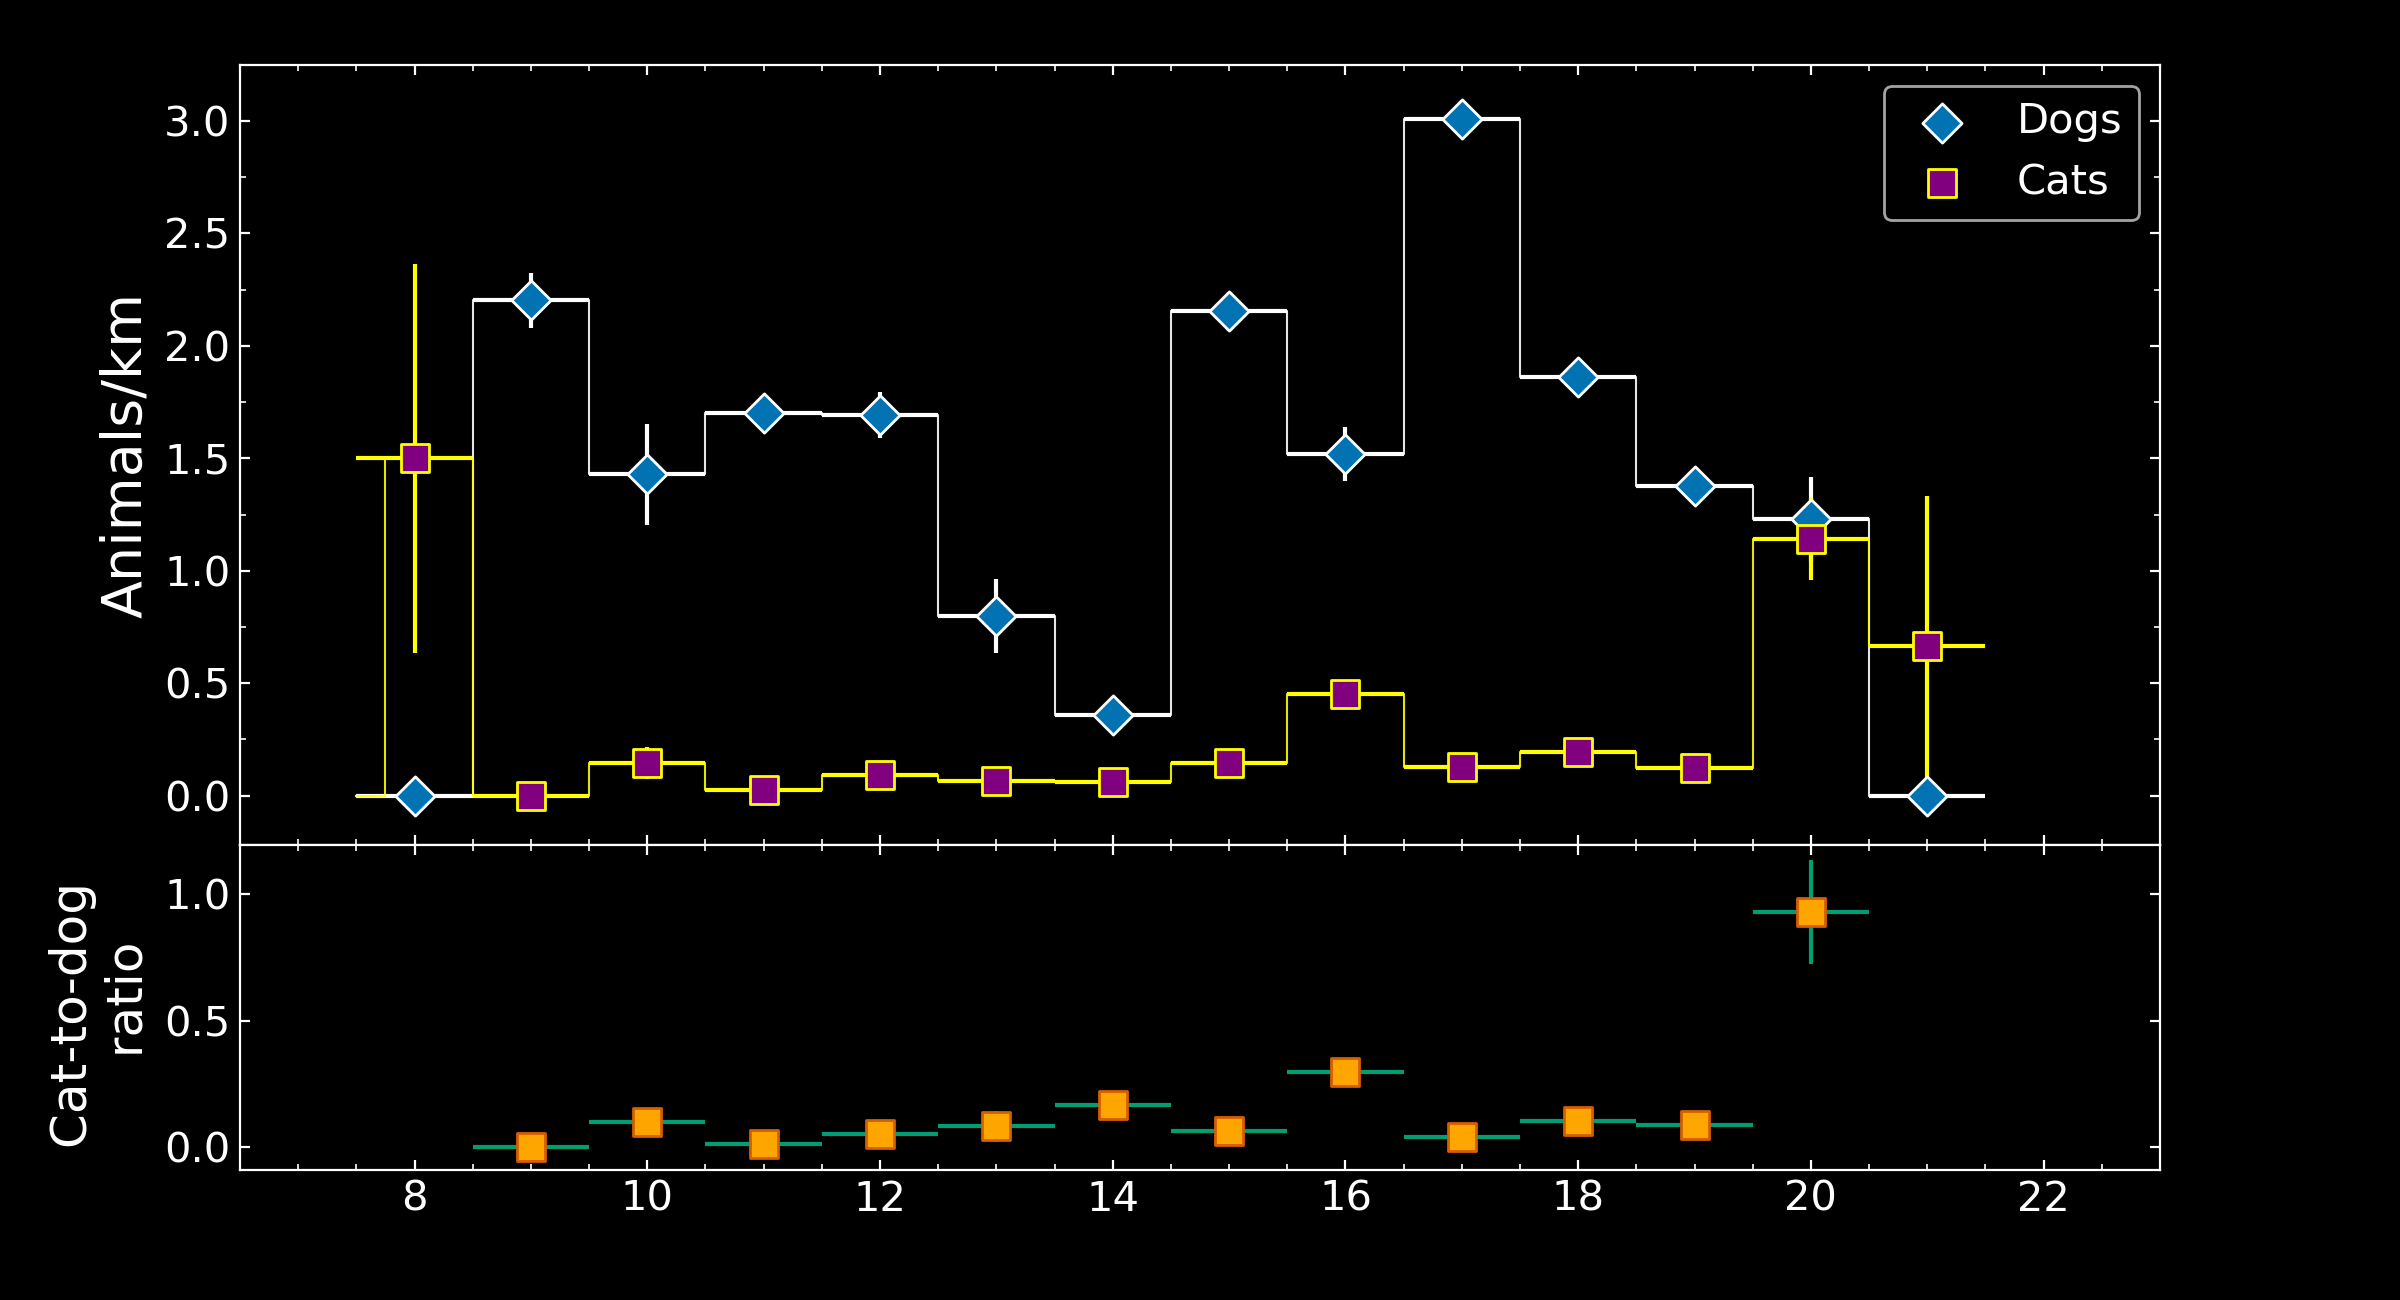

/Users/pwise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [7]:
# Let's split the data up into start time, and plot some histograms
dogspotting['t_start_hour'] =dogspotting['dt_start'].apply(lambda x: x.hour).astype(float)

interval=1
time_groups = dogspotting.groupby(pd.cut(dogspotting['t_start_hour'],
                                         bins=np.linspace(dogspotting['t_start_hour'].min()-0.5,
                                                          dogspotting['t_start_hour'].max()+0.5,
                                                int(((dogspotting['t_start_hour'].max()- dogspotting['t_start_hour'].min())/interval)+2))))

bins=np.linspace(dogspotting['t_start_hour'].min()-0.5,
                                                          dogspotting['t_start_hour'].max()+0.5,
                                                int(((dogspotting['t_start_hour'].max()- dogspotting['t_start_hour'].min())/interval)+2))




ft = plt.figure(figsize=(12,6.5))

# definitions for the axes
left, width = 0.1, 0.8
bottom, height = 0.1, 0.25
spacing = 0.00
rect_small = [left, bottom, width, height]
rect_big = [left, bottom + height + spacing, width, 0.6]

axt = plt.axes(rect_big)
axcdrt = plt.axes(rect_small)

for t,g in time_groups:
    labelc=labeld=None
    if t.left ==dogspotting['t_start_hour'].min()-0.5:
        labelc ='Cats'
        labeld ='Dogs'
    mid = (float(t.left)+float(t.right))/2
    
    if len(g)>0:
        stderrd = np.sqrt(g['N (Dogs)'].sum()/len(g))
        stderrc = np.sqrt(g['N (Cats)'].sum()/len(g))
        
    else:
        stderrd = stderrc = 0
    if g['Distance (km)'].sum() !=0:
        
        axt.scatter(mid,g['N (Dogs)'].sum()/g['Distance (km)'].sum(),c='b',marker='D',s=100,edgecolor='w',zorder=3,
                   label=labeld)
        axt.errorbar(mid,g['N (Dogs)'].sum()/g['Distance (km)'].sum(),
                     xerr=interval/2,yerr =stderrd/g['Distance (km)'].sum(),c='w',marker=None,linestyle=None,zorder=1)
        
        axt.scatter(mid,g['N (Cats)'].sum()/g['Distance (km)'].sum(),c='purple',marker='s',s=100,edgecolor='yellow',zorder=3,
                   label=labelc)
        axt.errorbar(mid,g['N (Cats)'].sum()/g['Distance (km)'].sum(),
                     xerr=interval/2,yerr =stderrc/g['Distance (km)'].sum(),c='yellow',marker=None,linestyle=None,zorder=1)
        if g['N (Dogs)'].sum()>0:
            axcdrt.scatter(mid,g['N (Cats)'].sum()/g['N (Dogs)'].sum(),c='orange',marker='s',s=100,edgecolor='r',zorder=3,
                   label=labelc)
            axcdrt.errorbar(mid,g['N (Cats)'].sum()/g['N (Dogs)'].sum(),
                     xerr=interval/2,yerr =quadrature(g['N (Cats)'].sum()/g['N (Dogs)'].sum(),
                                                      g['N (Cats)'].sum(),stderrc,g['N (Dogs)'].sum(),stderrd),
                        c='g',marker=None,linestyle=None,zorder=1)
        
    else:
        axt.scatter(mid,0,c='b',marker='D',s=100,edgecolor='w')
        axt.errorbar(mid,0,c='b',xerr=interval/2,marker=None,linestyle=None)

sums =time_groups.aggregate(sum)

first_hours,ddr,dcr = [7.5],[0],[0]
for i in sums.index:
    
    if sums['Distance (km)'].loc[i]>0:
        first_hours.append((i.left+i.right)/2)
        ddr.append(sums['N (Dogs)'].loc[i]/sums['Distance (km)'].loc[i])
        dcr.append(sums['N (Cats)'].loc[i]/sums['Distance (km)'].loc[i])
    else:
        #ddr.append(0)
        #dcr.append(0)
        pass
axt.step(first_hours,ddr,where='mid',linewidth=0.75,alpha=0.9,c='w')
axt.step(first_hours,dcr,where='mid',linewidth=0.75,alpha=0.9,c='yellow')

axt.set_xlabel('Start time',size=20)
axt.set_ylabel('Animals/km',size=20)
axcdrt.set_ylabel('Cat-to-dog \n ratio',size=18)
axt.legend(fontsize=15)
#axcdrt.yaxis.set_major_locator(MultipleLocator(0.25))
axt.yaxis.set_minor_locator(MultipleLocator(0.25))
#axcdrt.yaxis.set_minor_locator(MultipleLocator(0.1))
for ax in [axt,axcdrt]:
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.set_xlim(6.5,23)
    ax.tick_params(which='both',direction='in',right=True,top=True,labelsize=15)


plt.subplots_adjust(bottom=0.15,left=0.08)
plt.savefig('figs/Animals_per_km')

In [8]:
def guess_activity(row):
    pace = (row['duration']/row['Distance (km)'])/60.
    if pace > 9:
        return 'Walk'
    elif pace <3.5:
        return 'Ride'
    else:
        return 'Run'
    

dogspotting['Activity'] = dogspotting.apply(guess_activity,axis=1)

<IPython.core.display.Javascript object>


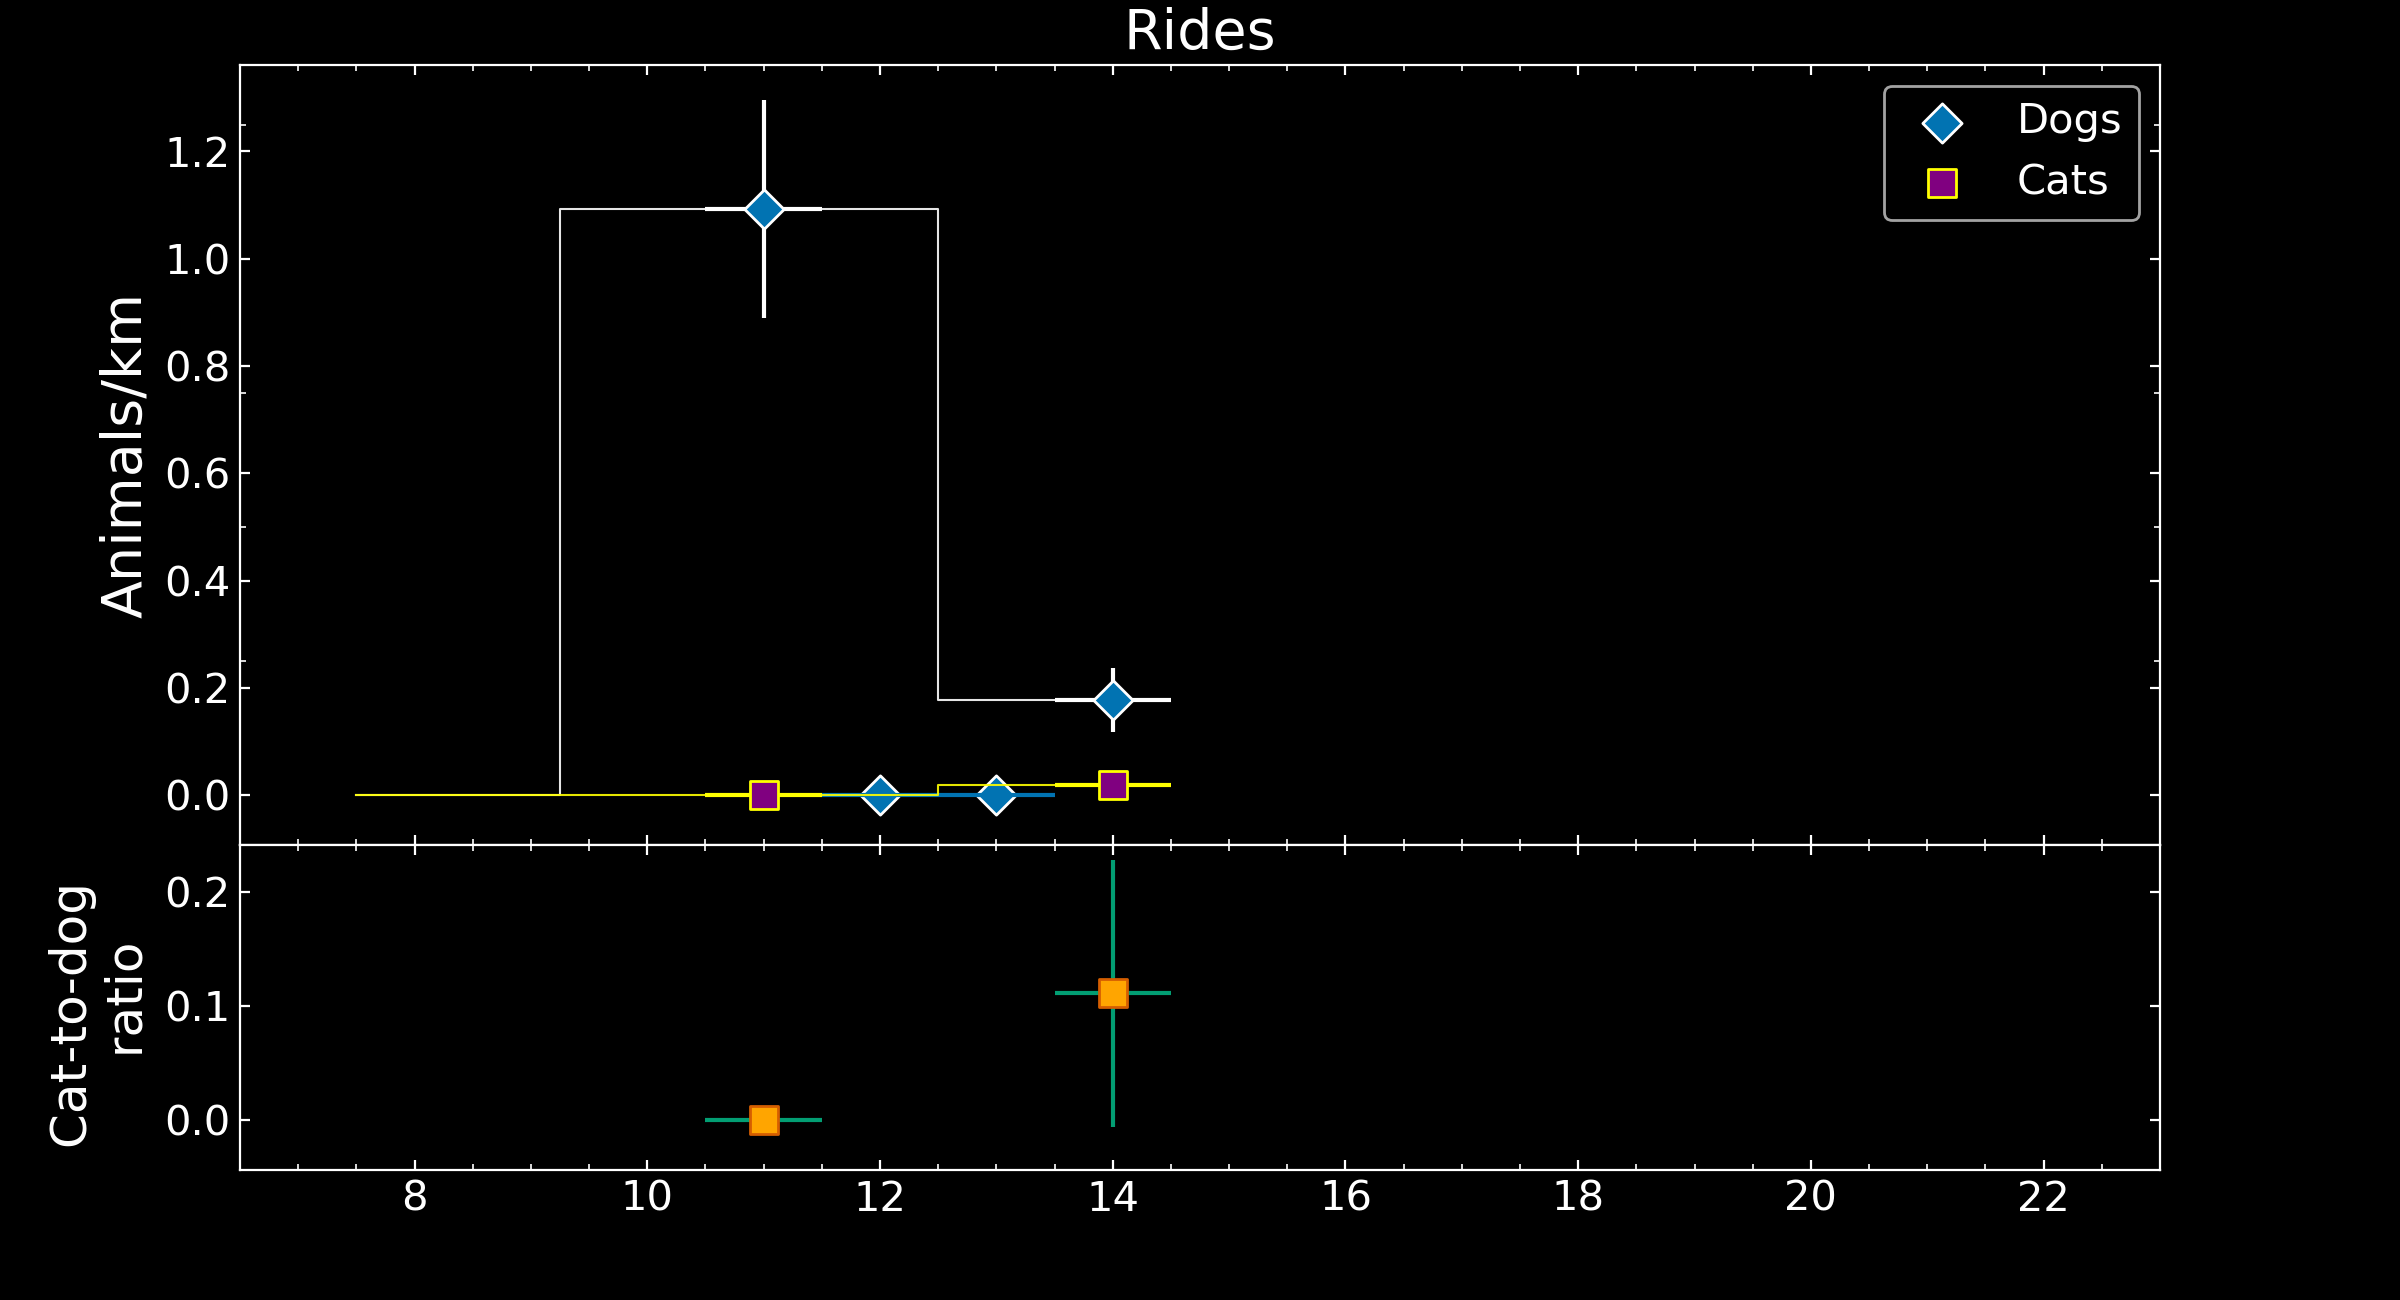

/Users/pwise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


<IPython.core.display.Javascript object>


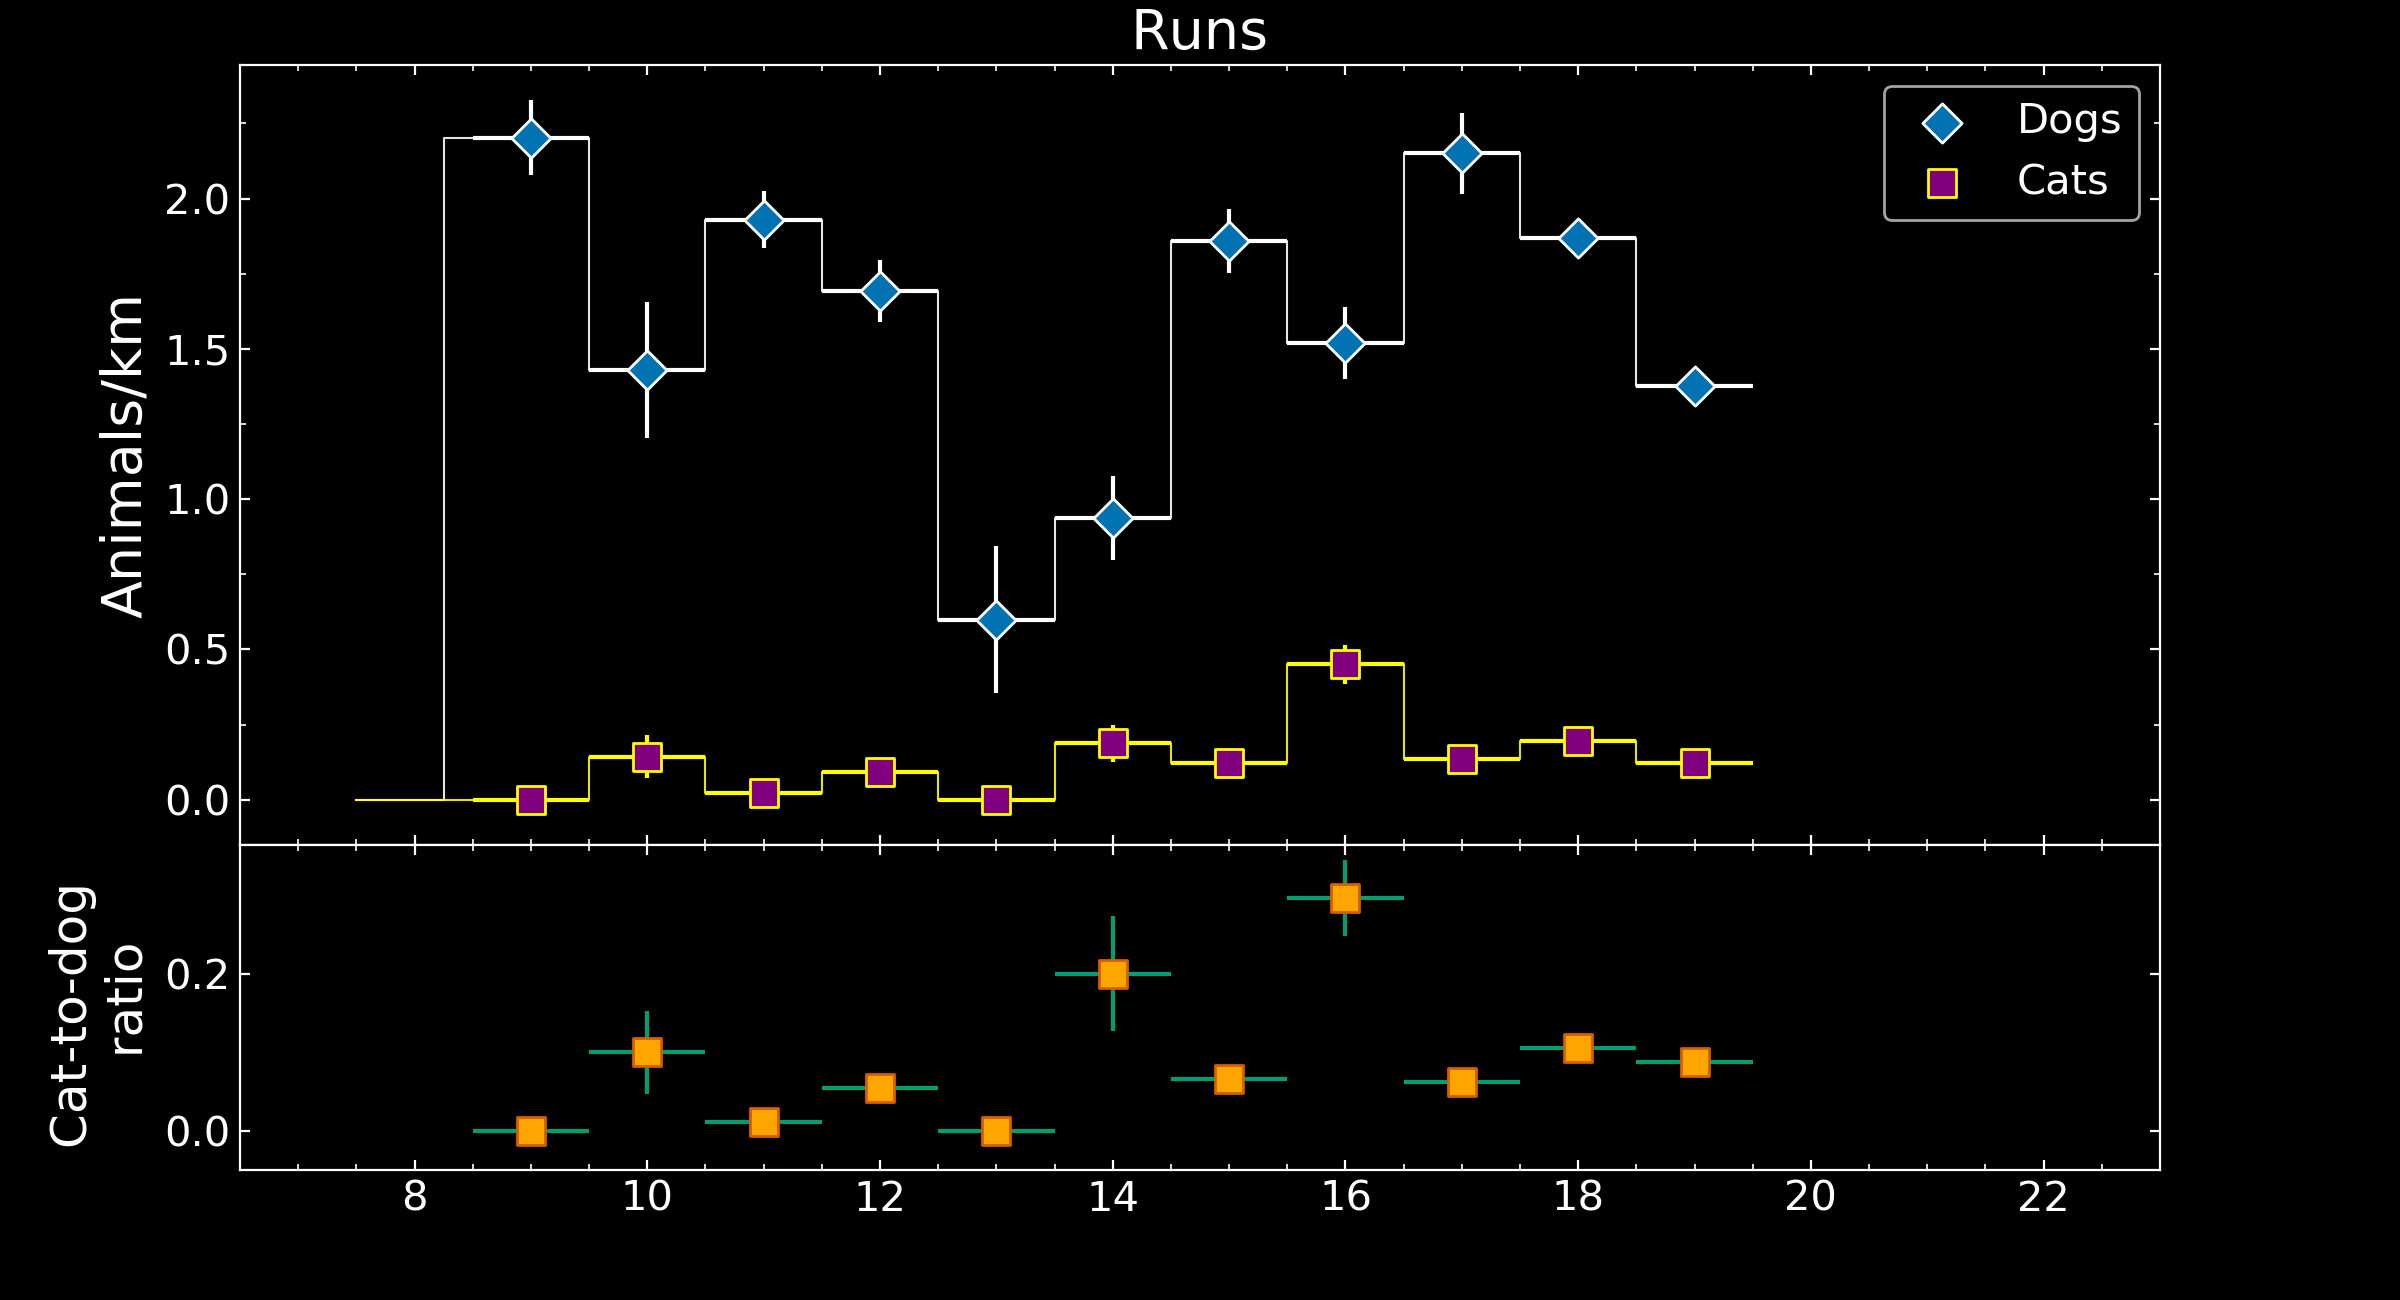

/Users/pwise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


<IPython.core.display.Javascript object>


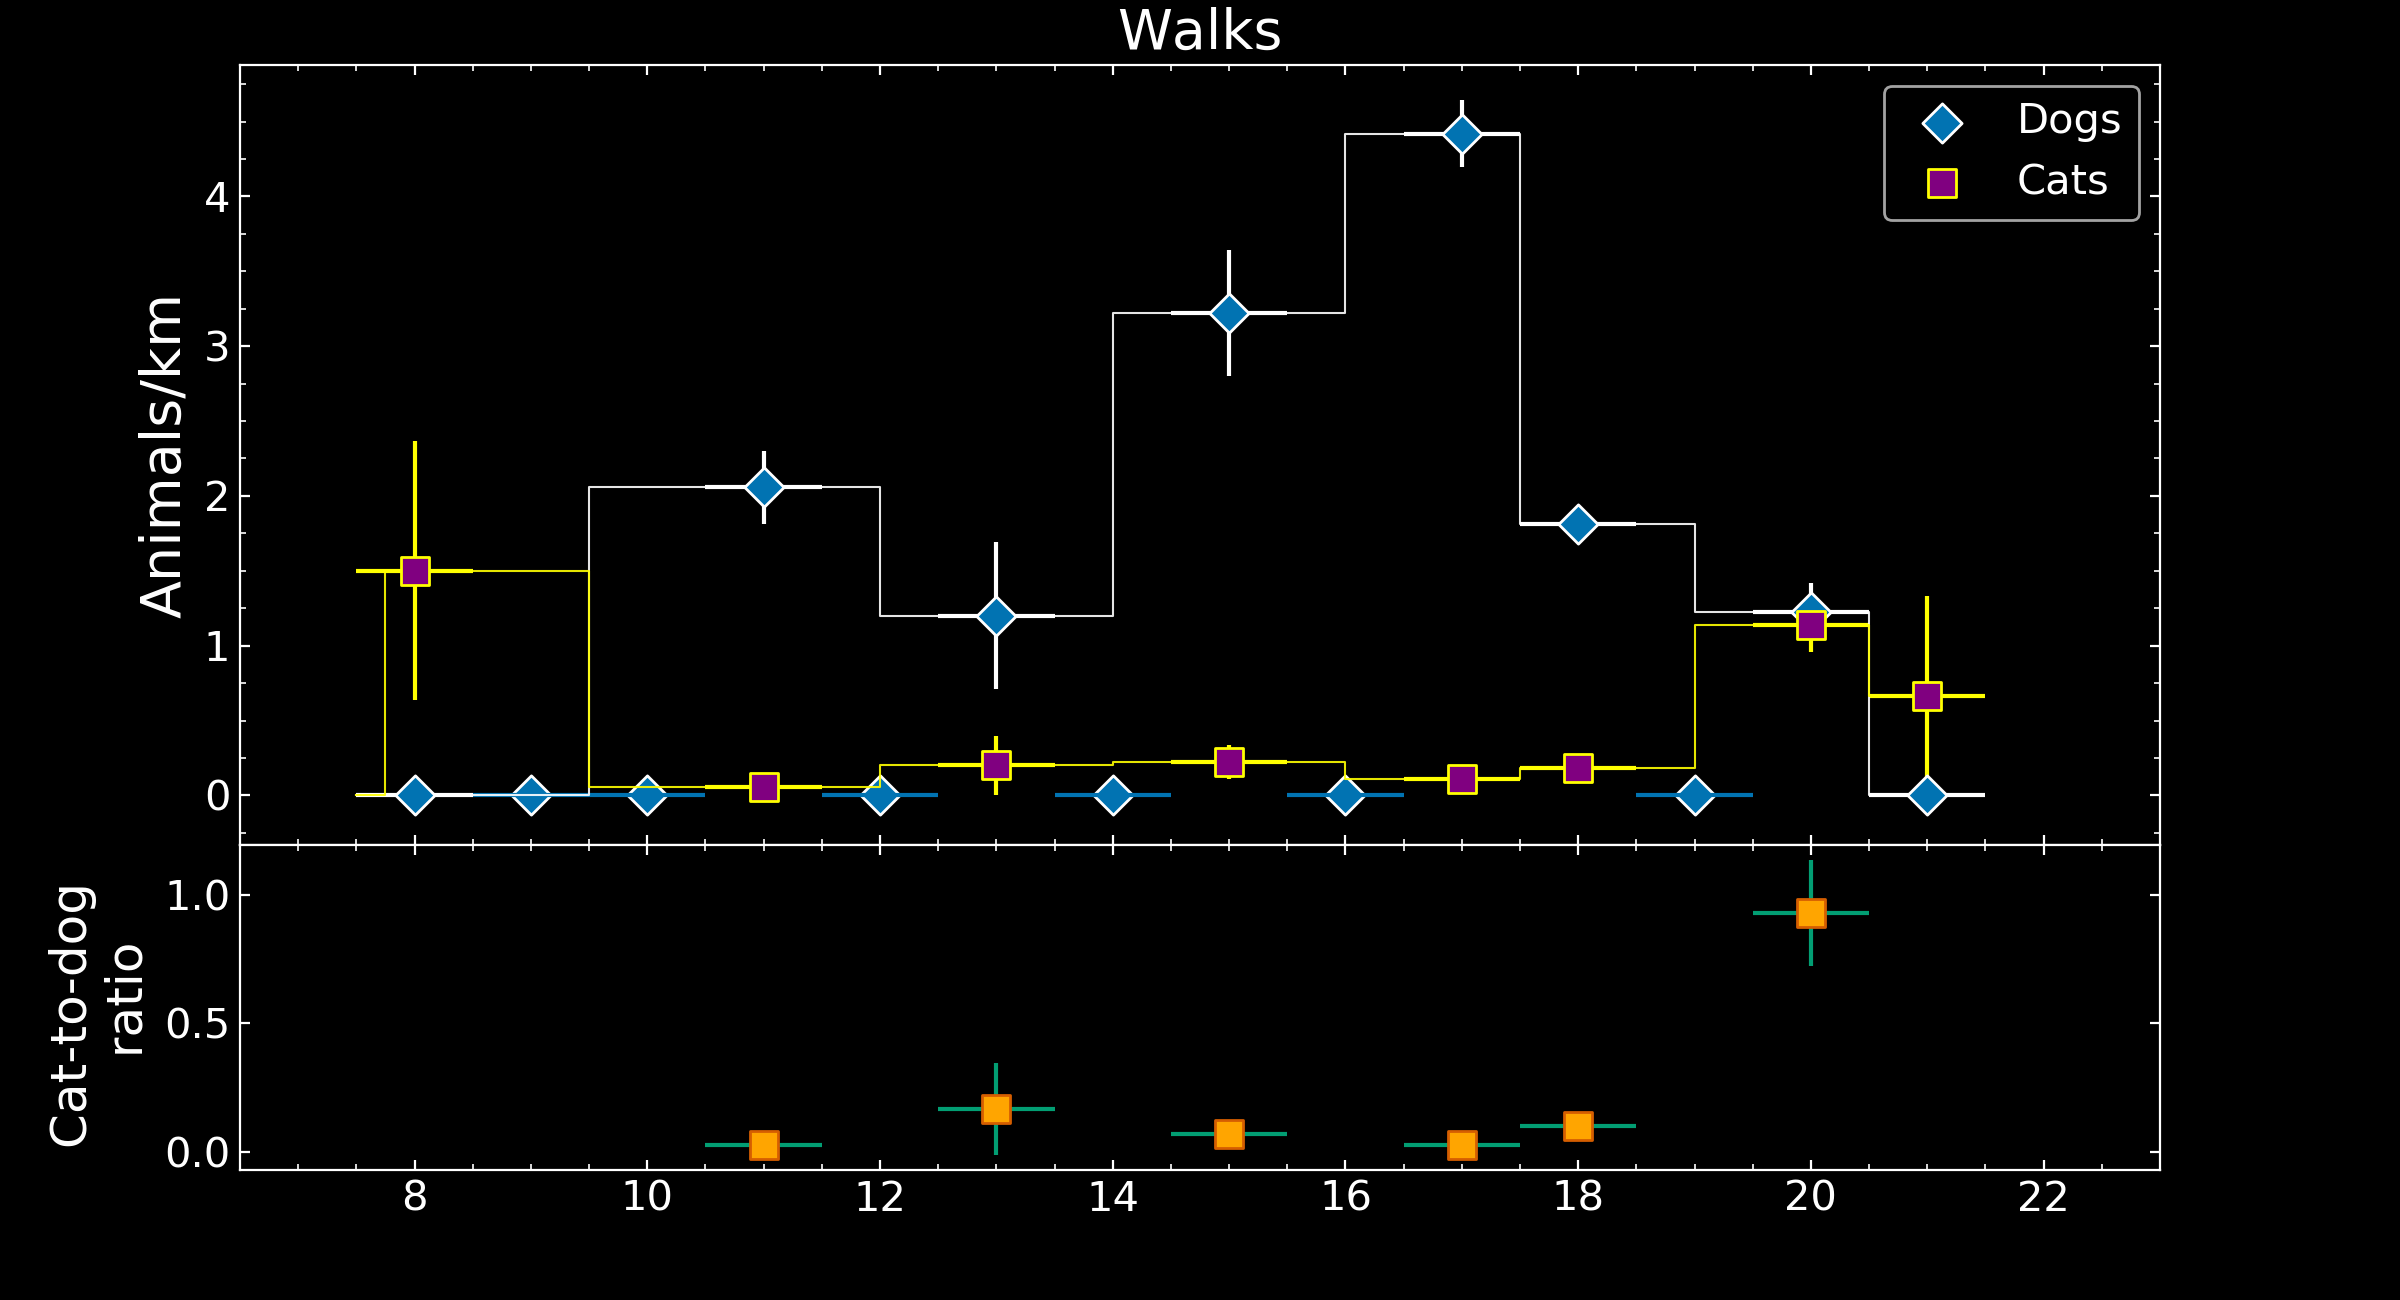

In [9]:
# Same as above, but split by activity type
interval=1
sum_df = pd.DataFrame(columns=[dogspotting.Activity.unique()])
for an,ag in dogspotting.groupby('Activity'):
    time_groups = ag.groupby(pd.cut(ag['t_start_hour'],
                                             bins=np.linspace(ag['t_start_hour'].min()-0.5,
                                                              ag['t_start_hour'].max()+0.5,
                                                    int(((ag['t_start_hour'].max()- ag['t_start_hour'].min())/interval)+2))))

    bins=np.linspace(ag['t_start_hour'].min()-0.5,
                                                              ag['t_start_hour'].max()+0.5,
                                                    int(((ag['t_start_hour'].max()- ag['t_start_hour'].min())/interval)+2))




    ft = plt.figure(figsize=(12,6.5))

    # definitions for the axes
    left, width = 0.1, 0.8
    bottom, height = 0.1, 0.25
    spacing = 0.00
    rect_small = [left, bottom, width, height]
    rect_big = [left, bottom + height + spacing, width, 0.6]

    axt = plt.axes(rect_big)
    axcdrt = plt.axes(rect_small)
    axt.set_title('%ss'%an,size=20)
    for t,g in time_groups:
        labelc=labeld=None
        if t.left ==ag['t_start_hour'].min()-0.5:
            labelc ='Cats'
            labeld ='Dogs'
        mid = (float(t.left)+float(t.right))/2

        if len(g)>0:
            stderrd = np.sqrt(g['N (Dogs)'].sum()/len(g))
            stderrc = np.sqrt(g['N (Cats)'].sum()/len(g))

        else:
            stderrd = stderrc = 0
        if g['Distance (km)'].sum() !=0:

            axt.scatter(mid,g['N (Dogs)'].sum()/g['Distance (km)'].sum(),c='b',marker='D',s=100,edgecolor='w',zorder=3,
                       label=labeld)
            axt.errorbar(mid,g['N (Dogs)'].sum()/g['Distance (km)'].sum(),
                         xerr=interval/2,yerr =stderrd/g['Distance (km)'].sum(),c='w',marker=None,linestyle=None,zorder=1)

            axt.scatter(mid,g['N (Cats)'].sum()/g['Distance (km)'].sum(),c='purple',marker='s',s=100,edgecolor='yellow',zorder=3,
                       label=labelc)
            axt.errorbar(mid,g['N (Cats)'].sum()/g['Distance (km)'].sum(),
                         xerr=interval/2,yerr =stderrc/g['Distance (km)'].sum(),c='yellow',marker=None,linestyle=None,zorder=1)
            if g['N (Dogs)'].sum()>0:
                axcdrt.scatter(mid,g['N (Cats)'].sum()/g['N (Dogs)'].sum(),c='orange',marker='s',s=100,edgecolor='r',zorder=3,
                       label=labelc)
                axcdrt.errorbar(mid,g['N (Cats)'].sum()/g['N (Dogs)'].sum(),
                         xerr=interval/2,yerr =quadrature(g['N (Cats)'].sum()/g['N (Dogs)'].sum(),
                                                          g['N (Cats)'].sum(),stderrc,g['N (Dogs)'].sum(),stderrd),
                            c='g',marker=None,linestyle=None,zorder=1)

        else:
            axt.scatter(mid,0,c='b',marker='D',s=100,edgecolor='w')
            axt.errorbar(mid,0,c='b',xerr=interval/2,marker=None,linestyle=None)
    
    sums =time_groups.aggregate(sum)
    
    sum_df[an]=sums.sum(axis=0)
    first_hours,ddr,dcr = [7.5],[0],[0]
    for i in sums.index:

        if sums['Distance (km)'].loc[i]>0:
            first_hours.append((i.left+i.right)/2)
            ddr.append(sums['N (Dogs)'].loc[i]/sums['Distance (km)'].loc[i])
            dcr.append(sums['N (Cats)'].loc[i]/sums['Distance (km)'].loc[i])
        else:
            #ddr.append(0)
            #dcr.append(0)
            pass
    axt.step(first_hours,ddr,where='mid',linewidth=0.75,alpha=0.9,c='w')
    axt.step(first_hours,dcr,where='mid',linewidth=0.75,alpha=0.9,c='yellow')

    axt.set_xlabel('Start time',size=20)
    axt.set_ylabel('Animals/km',size=20)
    axcdrt.set_ylabel('Cat-to-dog \n ratio',size=18)
    axt.legend(fontsize=15)
    #axcdrt.yaxis.set_major_locator(MultipleLocator(0.25))
    axt.yaxis.set_minor_locator(MultipleLocator(0.25))
    #axcdrt.yaxis.set_minor_locator(MultipleLocator(0.1))
    for ax in [axt,axcdrt]:
        ax.xaxis.set_minor_locator(MultipleLocator(0.5))
        ax.set_xlim(6.5,23)
        ax.tick_params(which='both',direction='in',right=True,top=True,labelsize=15)


    plt.subplots_adjust(bottom=0.15,left=0.08)
    
    plt.savefig('figs/Animals_per_km_%s'%an)

/Users/pwise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<IPython.core.display.Javascript object>


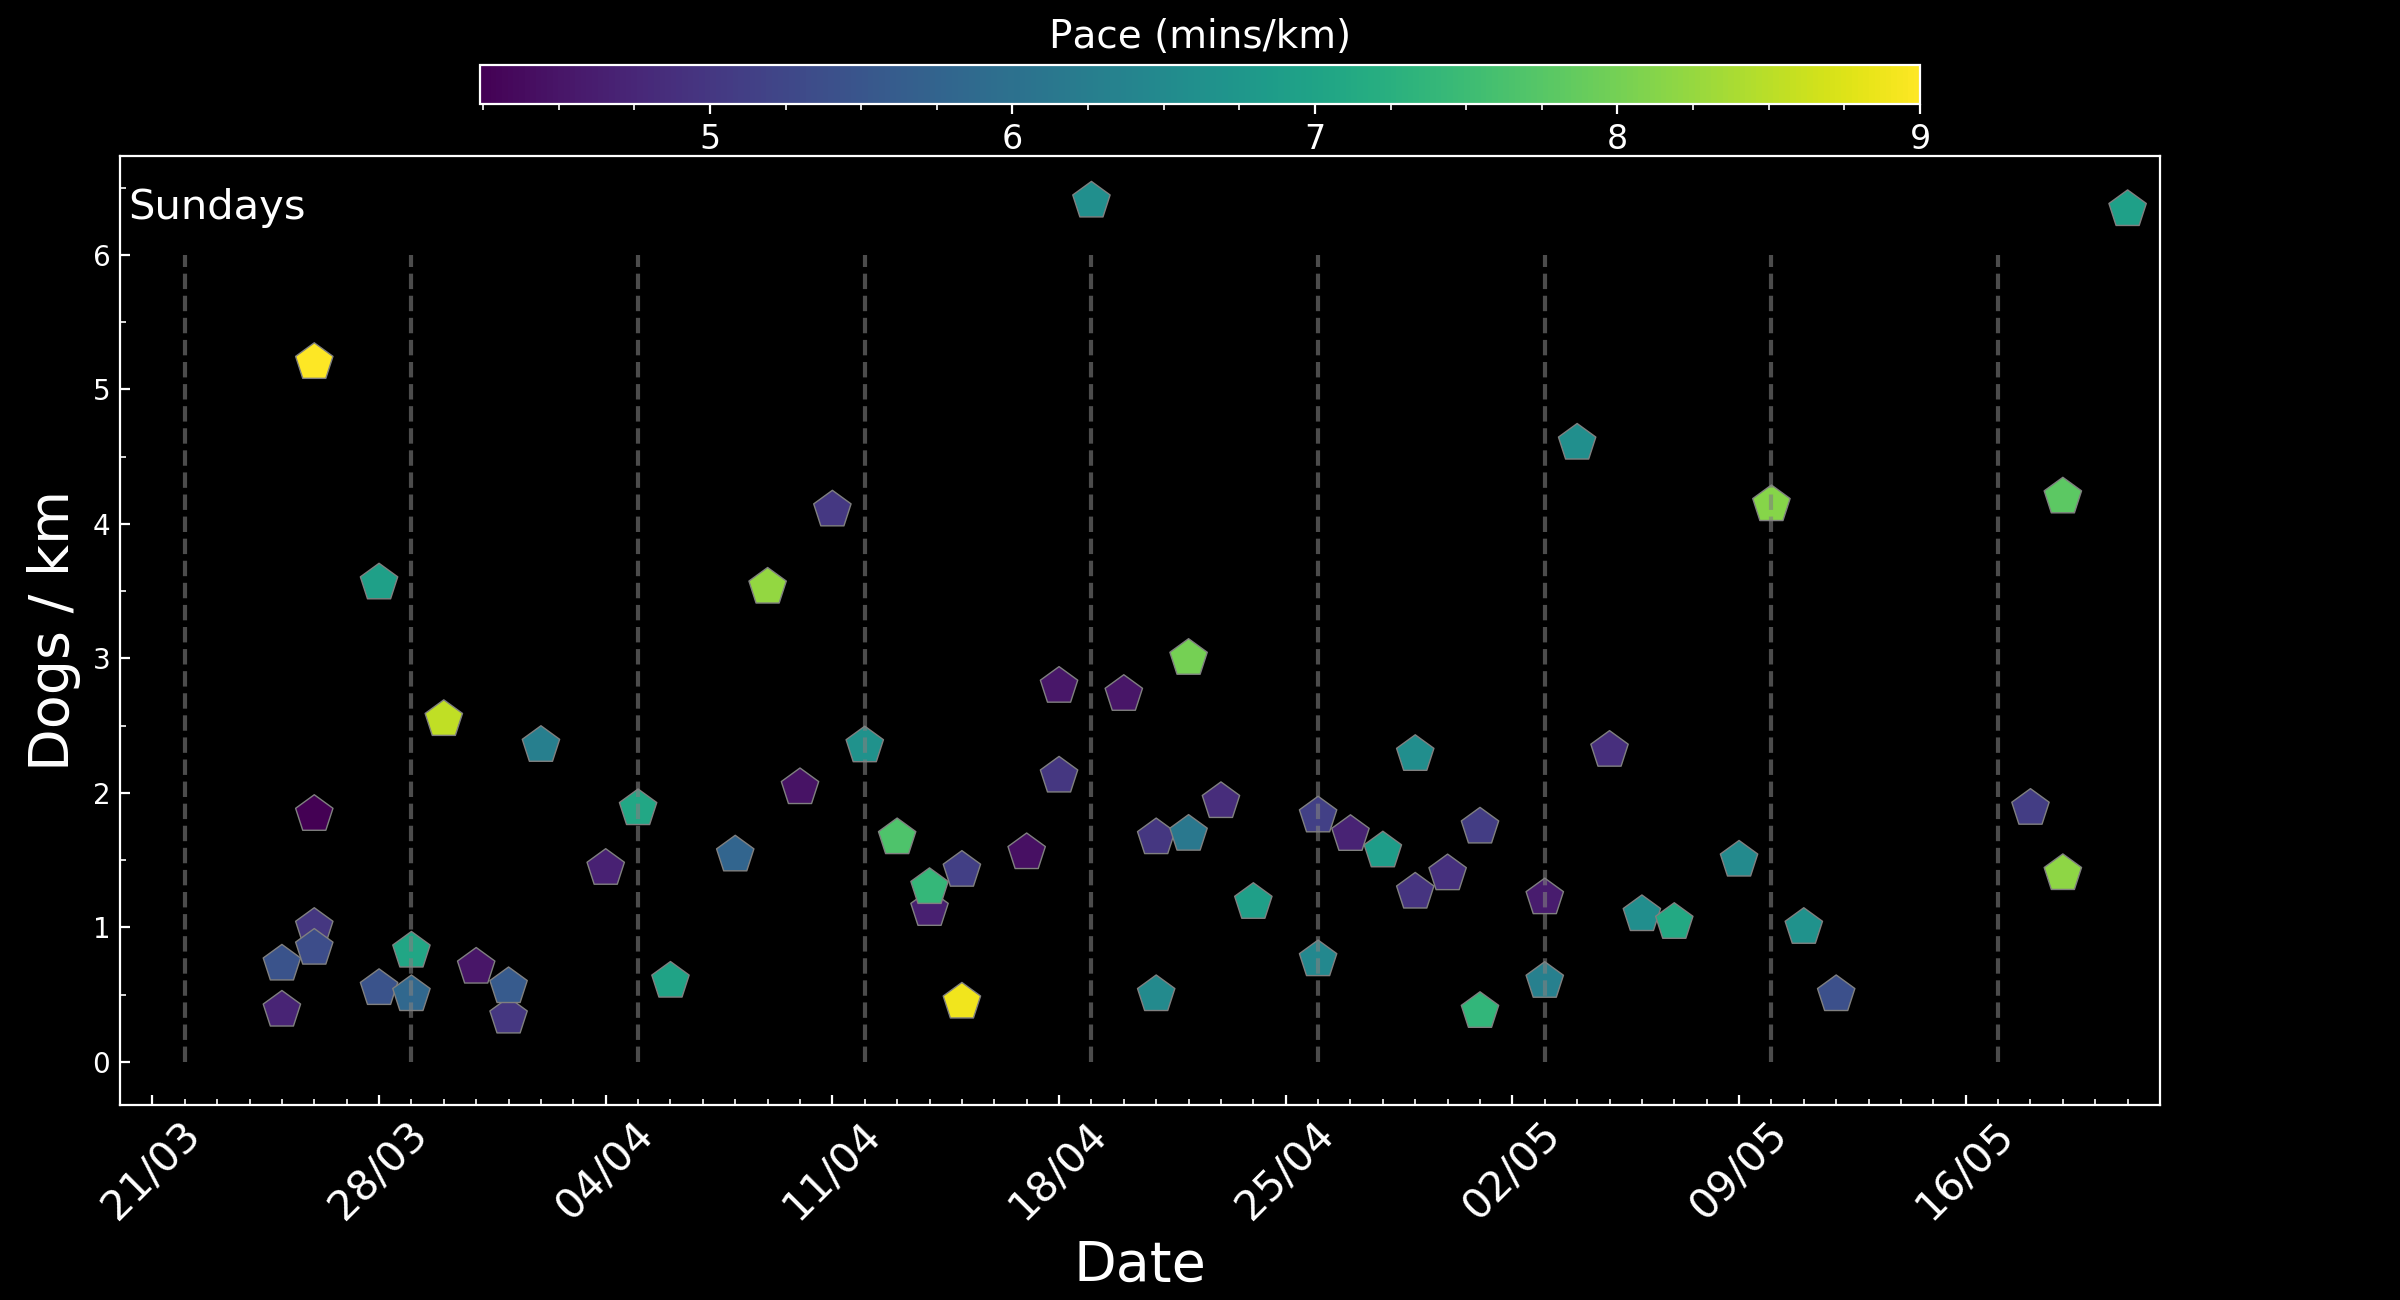

/Users/pwise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/pwise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [10]:
runs = dogspotting[dogspotting['Activity']=='Run']
runs['Pace'] = runs['duration']/runs['Distance (km)']/60.

fr,axr = plt.subplots(figsize=(12,6.5))
'''for a in runs.index:
    run = runs.loc[a]
    ddr = run['N (Dogs)']/run['Distance (km)']
    date = run['Date']
    axr.scatter()'''
runs['Date'] = pd.to_datetime(runs['Date'],format='%d/%m/%Y')
runs['Date'] = runs['Date'].apply(lambda x: x.date())
cm =axr.scatter(runs['Date'].values,runs['N (Dogs)']/runs['Distance (km)'],
                s=200,linewidth=0.5,edgecolor='grey',c=runs['Pace'],cmap='viridis',marker='p')
#axr.set_xticklabels(runs['Date'])
days = mdates.DayLocator(interval=1)
weeks = mdates.DayLocator(interval=7)
days_fmt = mdates.DateFormatter('%d/%m')
axr.xaxis.set_minor_locator(days)
axr.xaxis.set_major_locator(weeks)
axr.xaxis.set_major_formatter(days_fmt)
axr.xaxis.set_tick_params(rotation=45,which='both',direction='in',labelsize=15)
axr.yaxis.set_minor_locator(MultipleLocator(0.5))
axr.yaxis.set_tick_params(which='both',direction='in')
axr.set_xlim(datetime.date(2020,3,20),datetime.date.today()+pd.Timedelta('1 days'))
axr.set_xlabel('Date',size=20)
axr.set_ylabel('Dogs / km',size=20)
cax=plt.axes([0.2,0.92,0.6,0.03])
cb = fr.colorbar(cm,cax=cax,
                      orientation='horizontal',label='Pace',fraction=0.1)
cb.ax.xaxis.set_minor_locator(MultipleLocator(0.25))
cb.ax.tick_params(labelsize=12)
cb.set_label(label='Pace (mins/km)', size=14,labelpad=-50)
plt.subplots_adjust(bottom=0.15,left=0.05)
base = datetime.date(2020,3,15)
for dt in np.array([base+datetime.timedelta(days=i) for i in range(0,77,7)]):
    axr.vlines(dt,0,6,linestyle='--',color='grey',alpha=0.6)
axr.annotate('Sundays',(datetime.date(2020,3,23),6.2),rotation=0,size=15,ha='center',va='bottom')

plt.savefig('figs/Animals_by_pace')

<IPython.core.display.Javascript object>


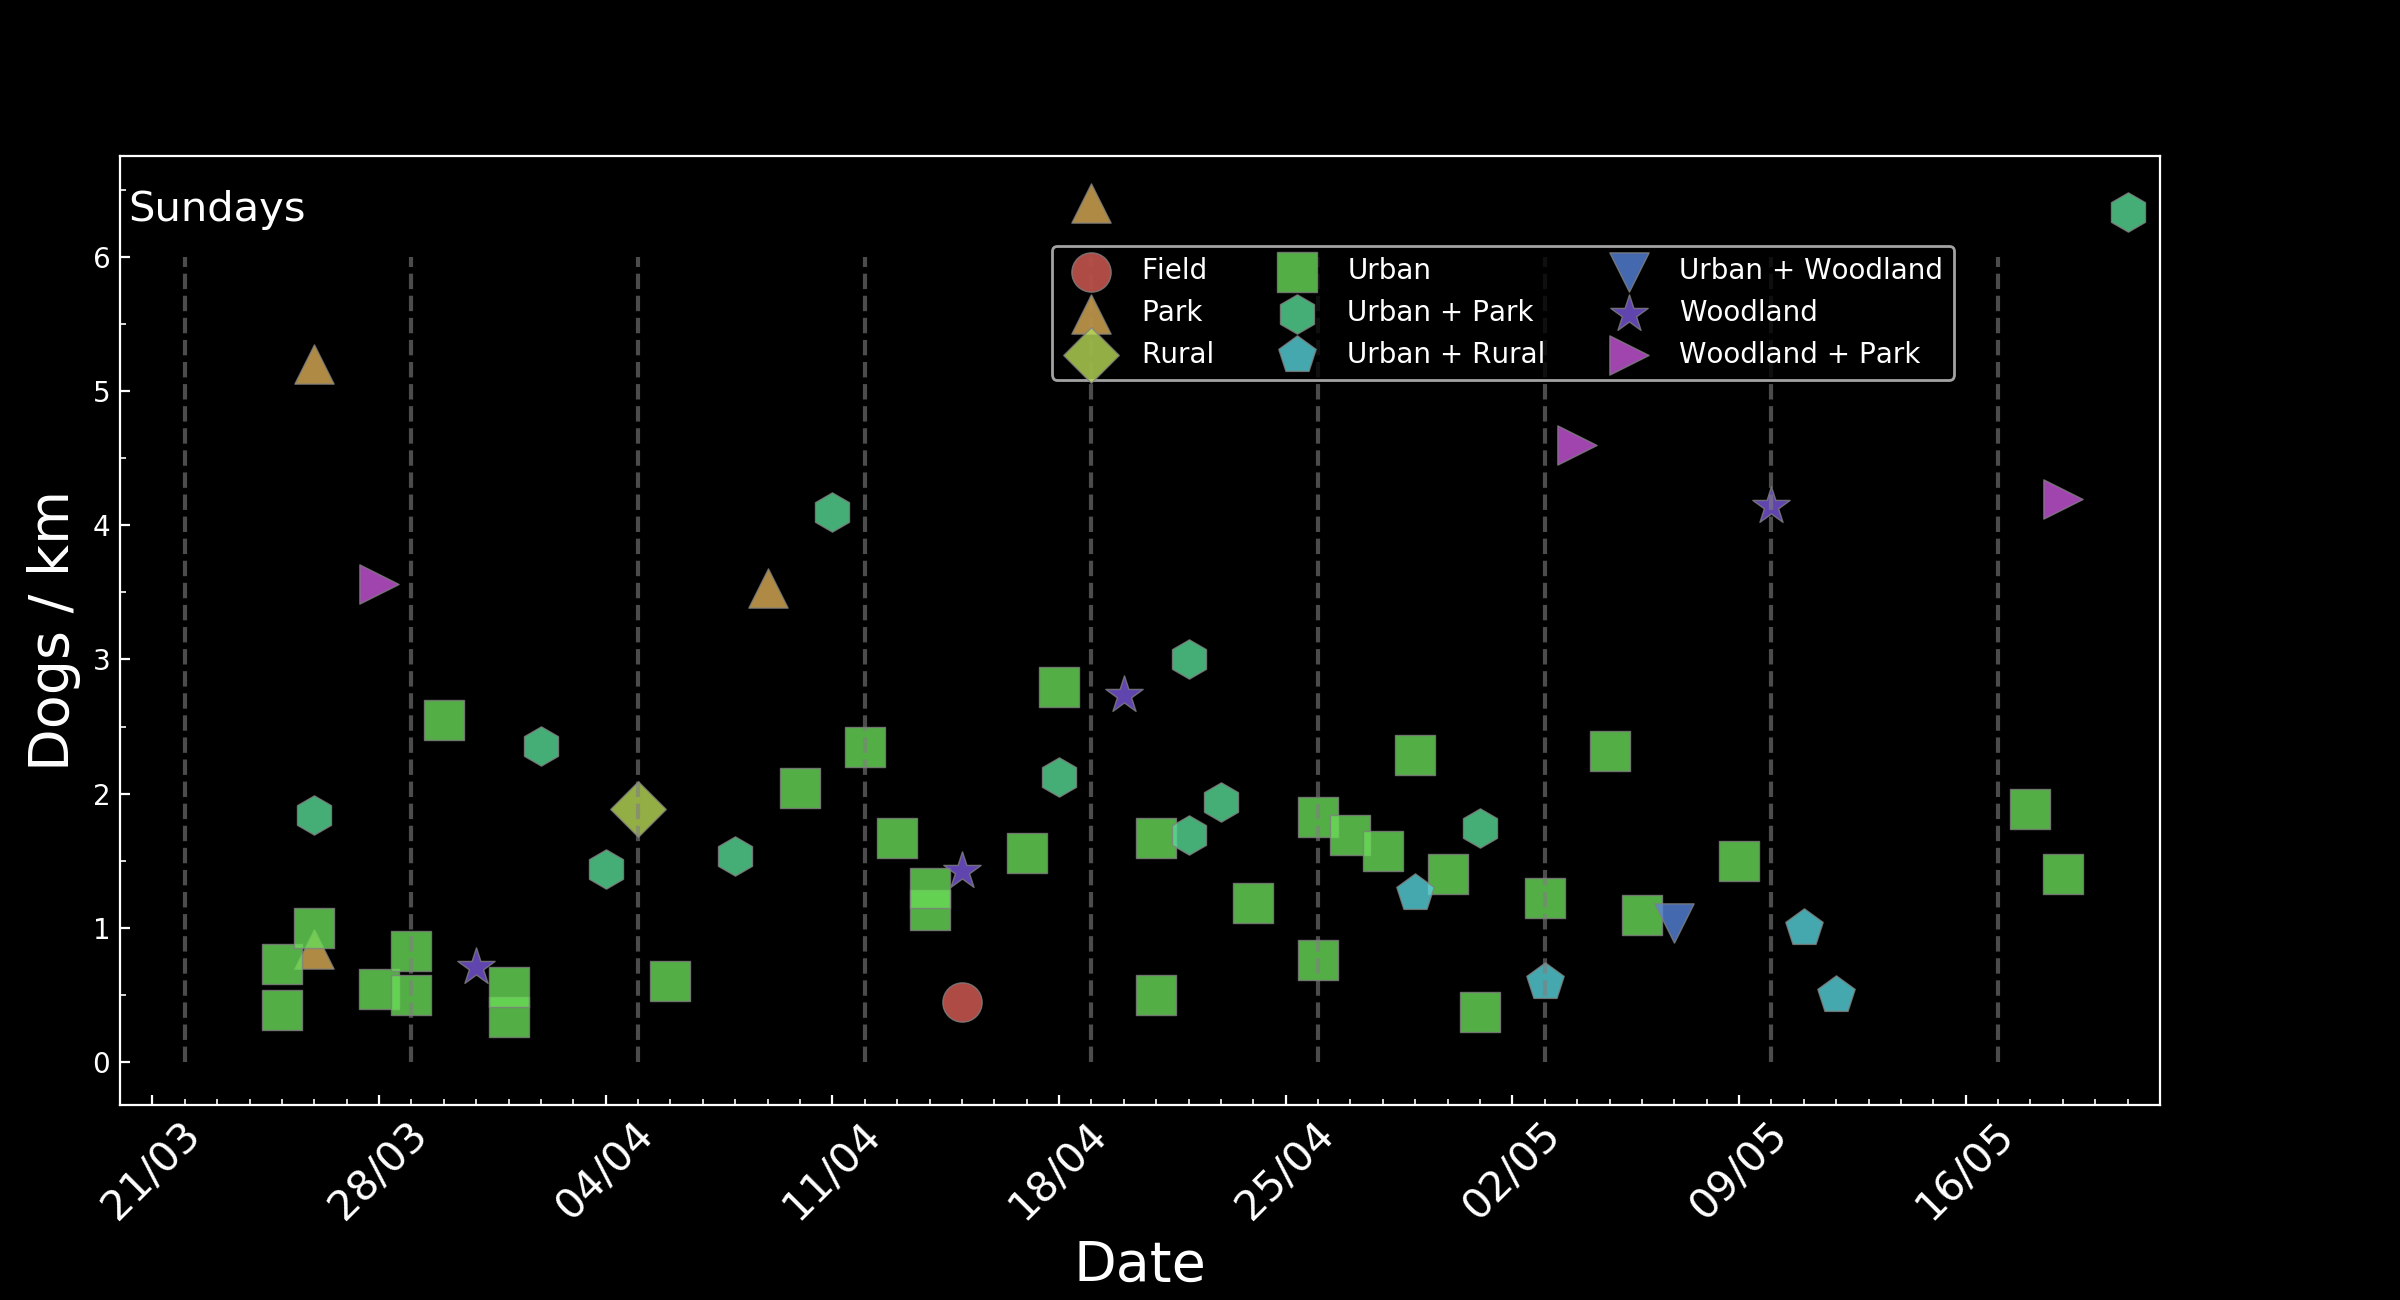

In [17]:
fre,axre = plt.subplots(figsize=(12,6.5))
'''for a in runs.index:
    run = runs.loc[a]
    ddr = run['N (Dogs)']/run['Distance (km)']
    date = run['Date']
    axr.scatter()'''
palette = itertools.cycle(sns.color_palette(palette='hls',n_colors=10))
markers = itertools.cycle(['o','^','D','s','h','p','v','*','>'])
for n,g in runs.groupby('Urban/Rural'):
    axre.scatter(g['Date'].values,g['N (Dogs)']/g['Distance (km)'],
                 s=200,linewidth=0.5,edgecolor='grey',color=next(palette),marker=next(markers),label=n,alpha=0.8)
    #axr.set_xticklabels(runs['Date'])
days = mdates.DayLocator(interval=1)
weeks = mdates.DayLocator(interval=7)
days_fmt = mdates.DateFormatter('%d/%m')
axre.xaxis.set_minor_locator(days)
axre.xaxis.set_major_locator(weeks)
axre.xaxis.set_major_formatter(days_fmt)
axre.xaxis.set_tick_params(rotation=45,which='both',direction='in',labelsize=15)
axre.yaxis.set_minor_locator(MultipleLocator(0.5))
axre.yaxis.set_tick_params(which='both',direction='in')
axre.set_xlim(datetime.date(2020,3,20),datetime.date.today()+pd.Timedelta('1 days'))
axre.set_xlabel('Date',size=20)
axre.set_ylabel('Dogs / km',size=20)

plt.subplots_adjust(bottom=0.15,left=0.05)
base = datetime.date(2020,3,15)
for dt in np.array([base+datetime.timedelta(days=i) for i in range(0,77,7)]):
    axre.vlines(dt,0,6,linestyle='--',color='grey',alpha=0.6)
axre.legend(bbox_to_anchor=(.45,0.92),ncol=3)
axre.annotate('Sundays',(datetime.date(2020,3,23),6.2),rotation=0,size=15,ha='center',va='bottom')
plt.savefig('figs/dogs_by_environment')


In [18]:
dogspotting['Dogs_per_km'] = dogspotting['N (Dogs)']/dogspotting['Distance (km)']
dogspotting['Cats_per_km'] = dogspotting['N (Cats)']/dogspotting['Distance (km)']

<IPython.core.display.Javascript object>


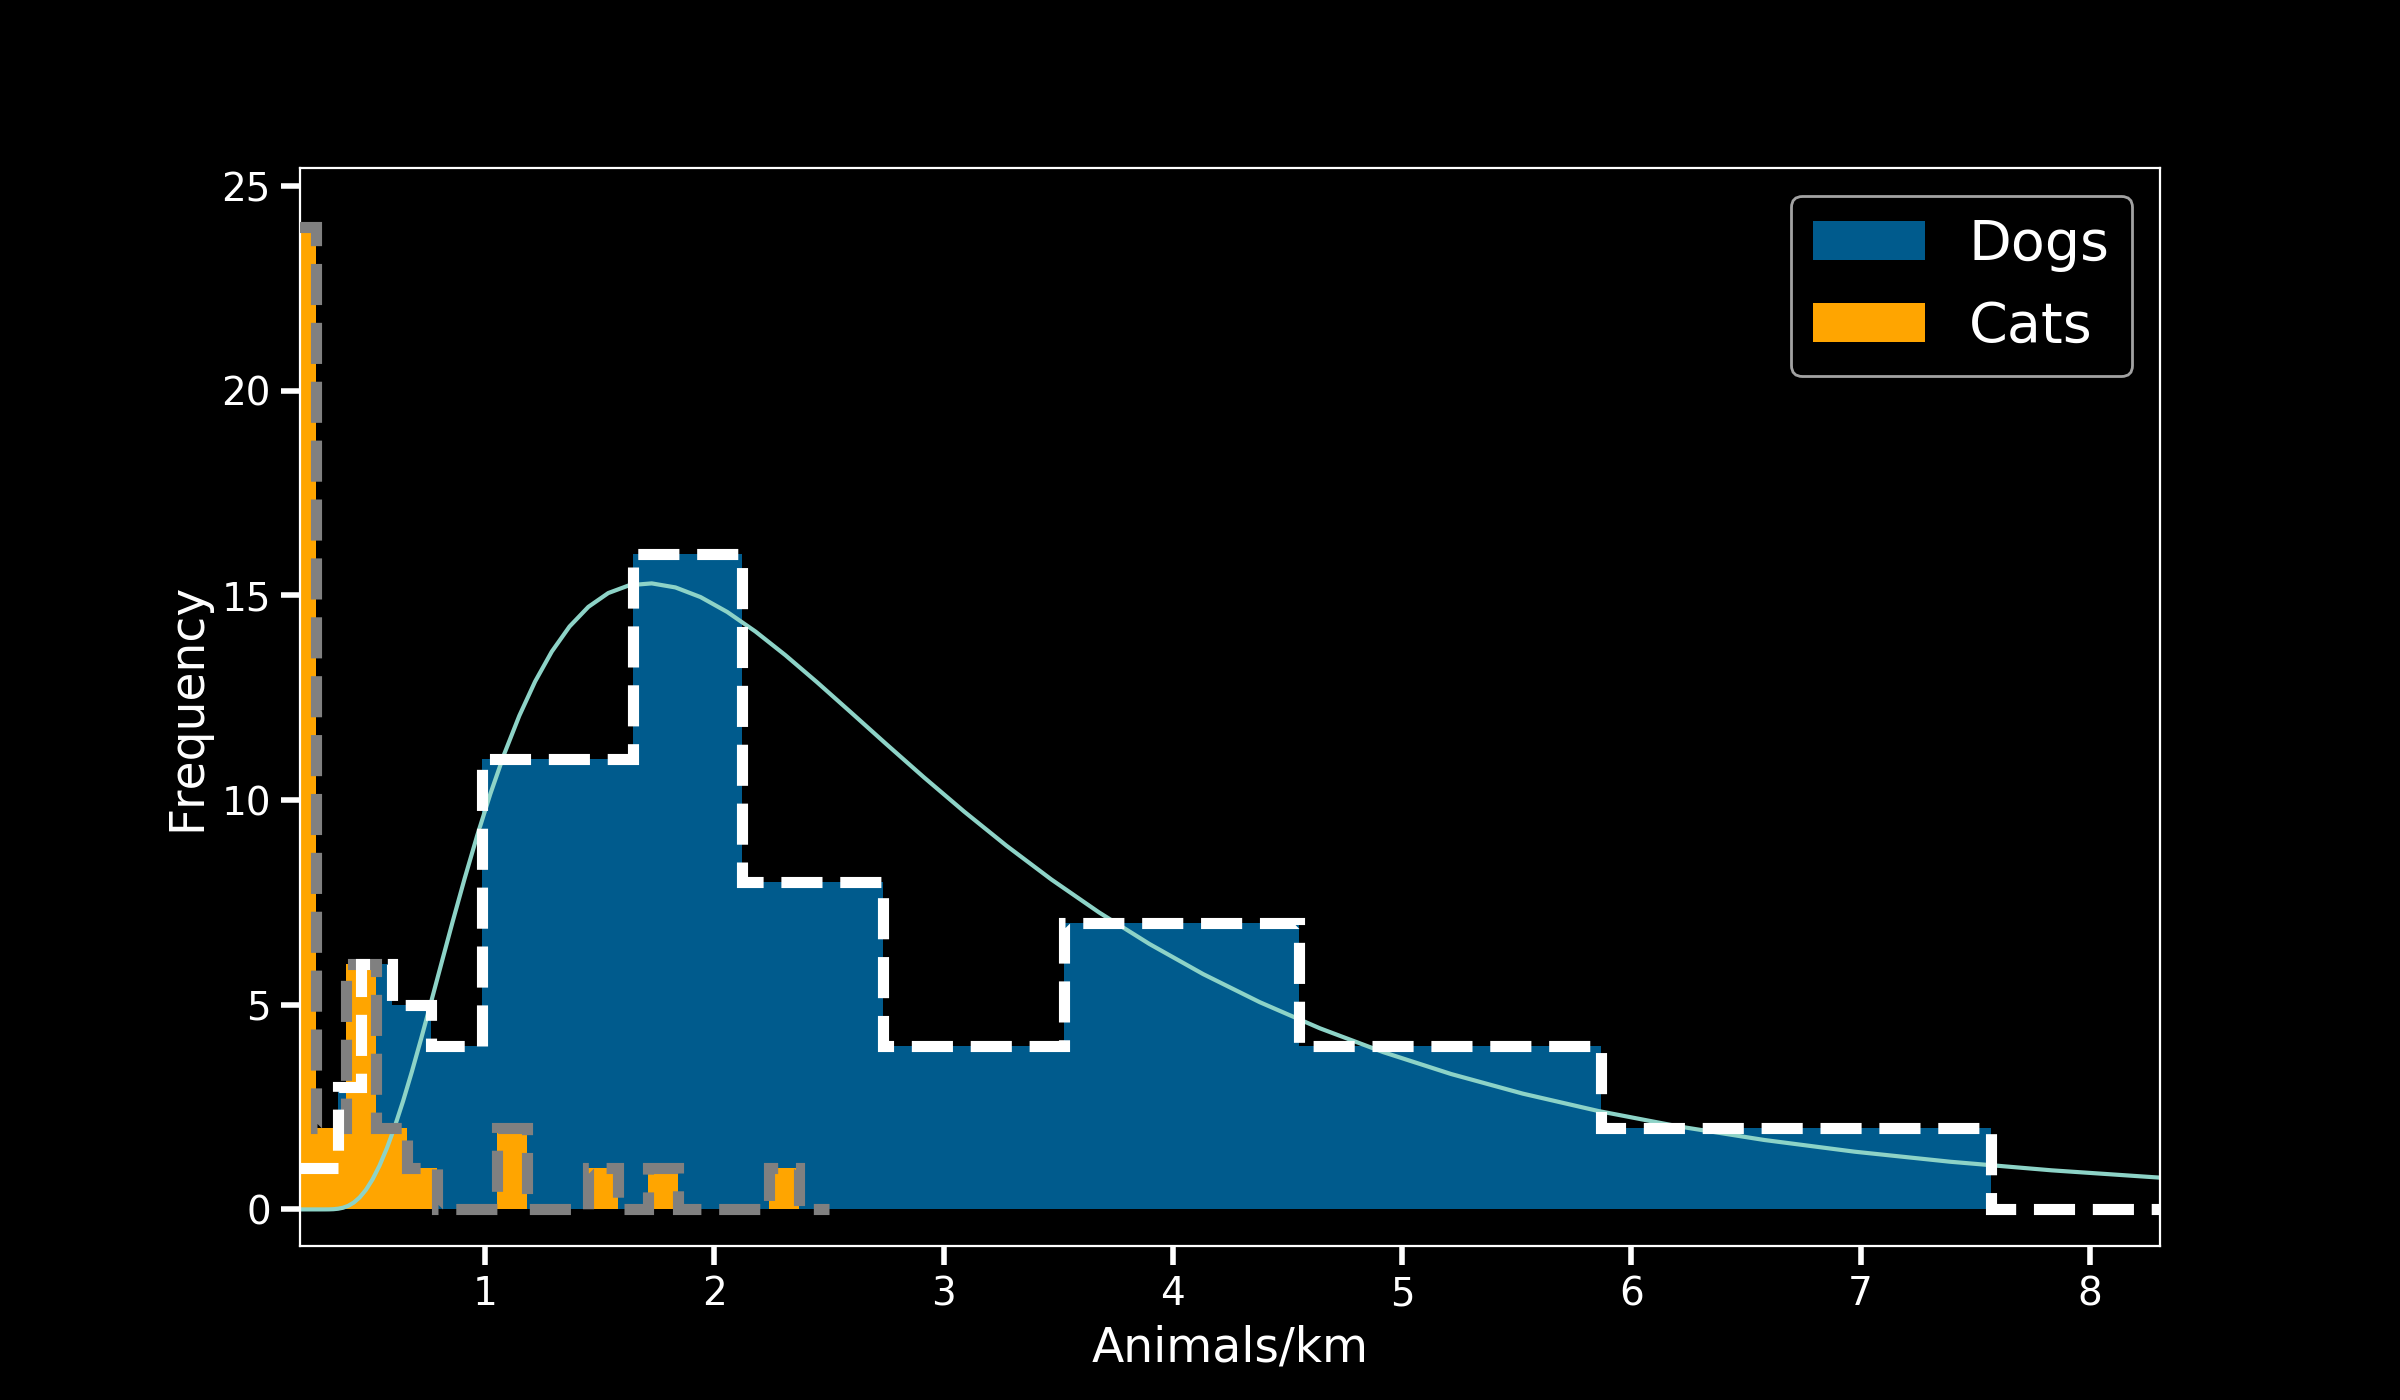

In [172]:
f,ax=plt.subplots(figsize=(12,7))
dogspotting['Cats per km'].hist(ax=ax,grid=False,bins=np.linspace(0,2.5,20),histtype='step',color='grey',lw=4,linestyle='--',zorder=6)
dogspotting['Dogs per km'].hist(ax=ax,grid=False,bins=np.logspace(-1,1.1,20),histtype='step',color='w',lw=4,linestyle='--',zorder=6)

dogspotting['Dogs per km'].hist(ax=ax,grid=False,bins=np.logspace(-1,1.1,20),alpha=0.8,lw=1,color='b',label='Dogs')
dogspotting['Cats per km'].hist(ax=ax,grid=False,bins=np.linspace(0,2.5,20),alpha=1,lw=1,color='orange',label='Cats')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('Animals/km',size=17)
ax.set_ylabel('Frequency',size=17)
ax.legend(fontsize=20)
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax.tick_params(which='both',length=7,width=2,labelsize=14)

In [174]:
from scipy import stats
xs=np.logspace(-1,1.5,100)
ax.plot(xs,stats.lognorm(0.7,loc=0.25,scale=2.38).pdf(xs)*50)
ax.vlines(dogspotting['Dogs_per_km'].median,0,20,linestyle=':',color='m')

TypeError: float() argument must be a string or a number, not 'method'

### np.log10(2.3)

<IPython.core.display.Javascript object>


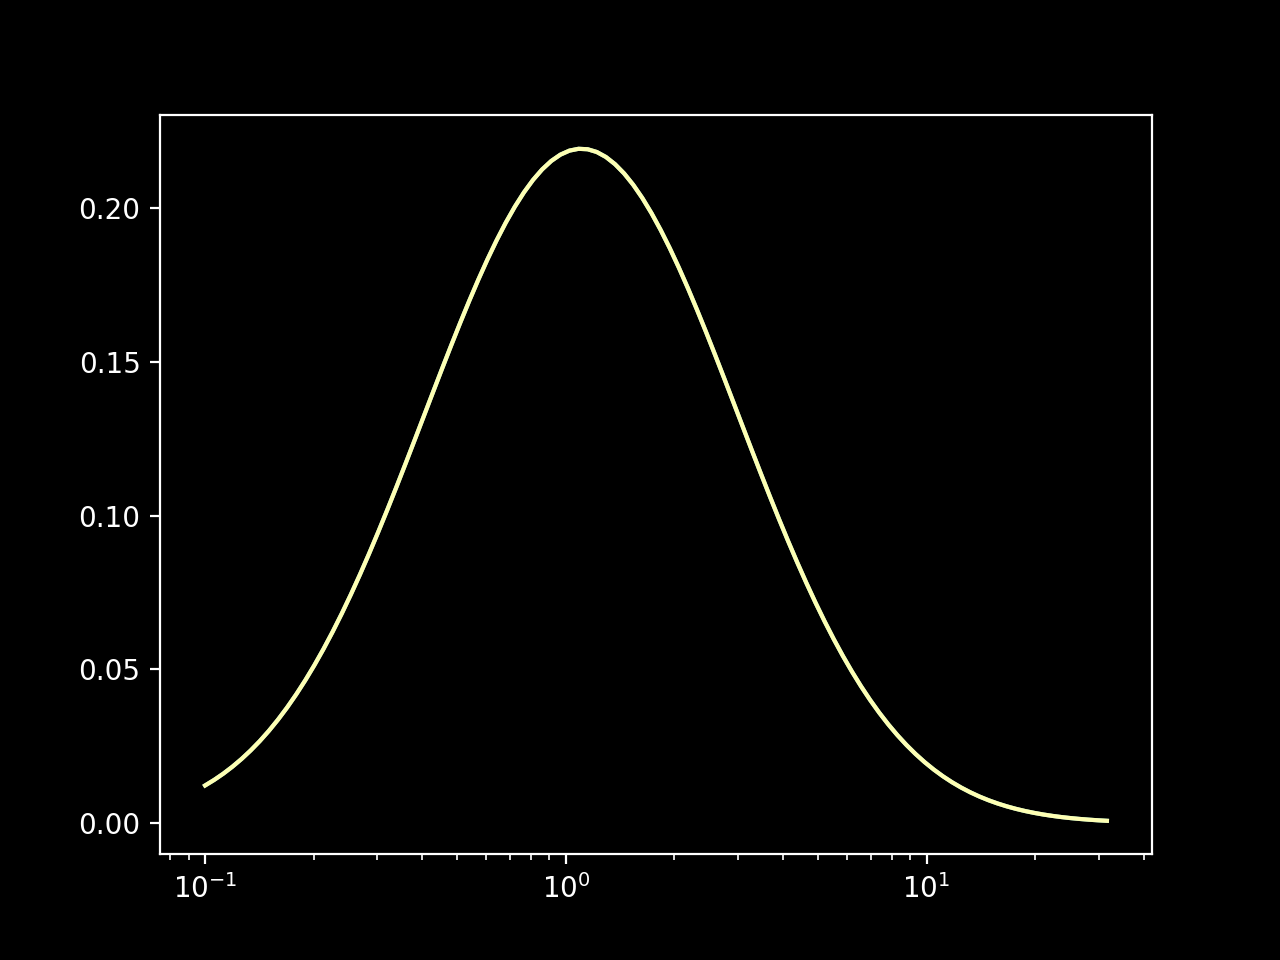

In [103]:
f,ax=plt.subplots()
xs=np.logspace(-1,1.5,100)
ax.plot(xs,stats.lognorm(1,loc=0,scale=3).pdf(xs))
ax.set_xscale('log')